<a href="https://colab.research.google.com/github/AubLambert/FraudDetection/blob/main/Fraud_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 0: Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from datetime import datetime

from scipy.stats import chi2_contingency
from scipy.stats import spearmanr
from scipy.stats import mode

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_curve, roc_auc_score, average_precision_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
import lightgbm as lgb
from lightgbm import LGBMClassifier
from lightgbm.callback import early_stopping
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier

# Step 1: Basic Analysis

## Import Data

In [ ]:
# Set pandas option to display all columns
pd.set_option('display.max_columns', None)

# Optional: Set the width to avoid line breaks
pd.set_option('display.width', None)

df = pd.read_csv('fraudTrain.csv', on_bad_lines='warn')  # or 'skip' or 'error'
df

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,28654,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,99160,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,ID,83252,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,MT,59632,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,VA,24433,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1296670,1296670,2020-06-21 12:12:08,30263540414123,fraud_Reichel Inc,entertainment,15.56,Erik,Patterson,M,162 Jessica Row Apt. 072,Hatch,UT,84735,37.7175,-112.4777,258,Geoscientist,1961-11-24,440b587732da4dc1a6395aba5fb41669,1371816728,36.841266,-111.690765,0
1296671,1296671,2020-06-21 12:12:19,6011149206456997,fraud_Abernathy and Sons,food_dining,51.70,Jeffrey,White,M,8617 Holmes Terrace Suite 651,Tuscarora,MD,21790,39.2667,-77.5101,100,"Production assistant, television",1979-12-11,278000d2e0d2277d1de2f890067dcc0a,1371816739,38.906881,-78.246528,0
1296672,1296672,2020-06-21 12:12:32,3514865930894695,fraud_Stiedemann Ltd,food_dining,105.93,Christopher,Castaneda,M,1632 Cohen Drive Suite 639,High Rolls Mountain Park,NM,88325,32.9396,-105.8189,899,Naval architect,1967-08-30,483f52fe67fabef353d552c1e662974c,1371816752,33.619513,-105.130529,0
1296673,1296673,2020-06-21 12:13:36,2720012583106919,"fraud_Reinger, Weissnat and Strosin",food_dining,74.90,Joseph,Murray,M,42933 Ryan Underpass,Manderson,SD,57756,43.3526,-102.5411,1126,Volunteer coordinator,1980-08-18,d667cdcbadaaed3da3f4020e83591c83,1371816816,42.788940,-103.241160,0


In [ ]:
df = df.drop('Unnamed: 0', axis=1)

## Descriptive Statistics

In [ ]:
df.describe()

,cc_num,amt,zip,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud
count,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06
mean,4.171920e+17,7.035104e+01,4.880067e+04,3.853762e+01,-9.022634e+01,8.882444e+04,1.349244e+09,3.853734e+01,-9.022646e+01,5.788652e-03
std,1.308806e+18,1.603160e+02,2.689322e+04,5.075808e+00,1.375908e+01,3.019564e+05,1.284128e+07,5.109788e+00,1.377109e+01,7.586269e-02
min,6.041621e+10,1.000000e+00,1.257000e+03,2.002710e+01,-1.656723e+02,2.300000e+01,1.325376e+09,1.902779e+01,-1.666712e+02,0.000000e+00
25%,1.800429e+14,9.650000e+00,2.623700e+04,3.462050e+01,-9.679800e+01,7.430000e+02,1.338751e+09,3.473357e+01,-9.689728e+01,0.000000e+00
50%,3.521417e+15,4.752000e+01,4.817400e+04,3.935430e+01,-8.747690e+01,2.456000e+03,1.349250e+09,3.936568e+01,-8.743839e+01,0.000000e+00
75%,4.642255e+15,8.314000e+01,7.204200e+04,4.194040e+01,-8.015800e+01,2.032800e+04,1.359385e+09,4.195716e+01,-8.023680e+01,0.000000e+00
max,4.992346e+18,2.894890e+04,9.978300e+04,6.669330e+01,-6.795030e+01,2.906700e+06,1.371817e+09,6.751027e+01,-6.695090e+01,1.000000e+00


In [ ]:
df.shape

(1296675, 22)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 22 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   trans_date_trans_time  1296675 non-null  object 
 1   cc_num                 1296675 non-null  int64  
 2   merchant               1296675 non-null  object 
 3   category               1296675 non-null  object 
 4   amt                    1296675 non-null  float64
 5   first                  1296675 non-null  object 
 6   last                   1296675 non-null  object 
 7   gender                 1296675 non-null  object 
 8   street                 1296675 non-null  object 
 9   city                   1296675 non-null  object 
 10  state                  1296675 non-null  object 
 11  zip                    1296675 non-null  int64  
 12  lat                    1296675 non-null  float64
 13  long                   1296675 non-null  float64
 14  city_pop          

In [ ]:
df.isnull().sum()

,0
trans_date_trans_time,0
cc_num,0
merchant,0
category,0
amt,0
first,0
last,0
gender,0
street,0
city,0


In [ ]:
df.select_dtypes(include=['int64', 'float64']).nunique()

,0
cc_num,983
amt,52928
zip,970
lat,968
long,969
city_pop,879
unix_time,1274823
merch_lat,1247805
merch_long,1275745
is_fraud,2


In [ ]:
df.select_dtypes(include=['object', 'category']).nunique()

,0
trans_date_trans_time,1274791
merchant,693
category,14
first,352
last,481
gender,2
street,983
city,894
state,51
job,494


# Step 2: EDA

In [ ]:
# Create a copy for EDA
df_viz = df.copy()

## Data Transformation

### Fraud Rate

In [ ]:
fraud_percent = (df['is_fraud'] == 1).sum()/(df.shape[0])

print(f"Fraud Percentage: {fraud_percent * 100:.5f}%")

Fraud Percentage: 0.57887%


### Correlation

#### Numerical correlation

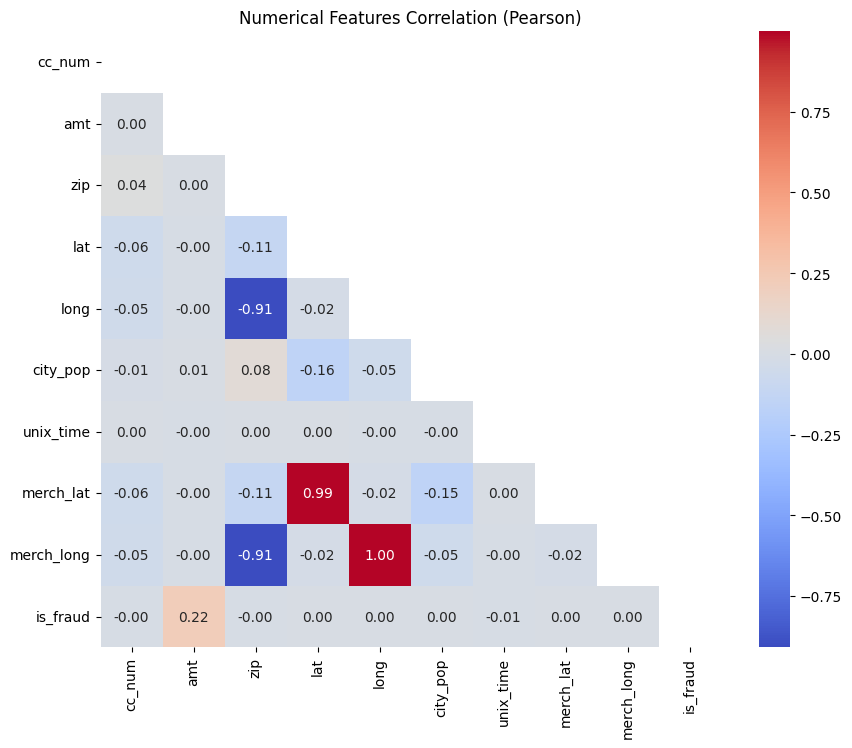

/tmp/ipython-input-170565288.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_features_signed.values, y=top_features_signed.index, palette="coolwarm")


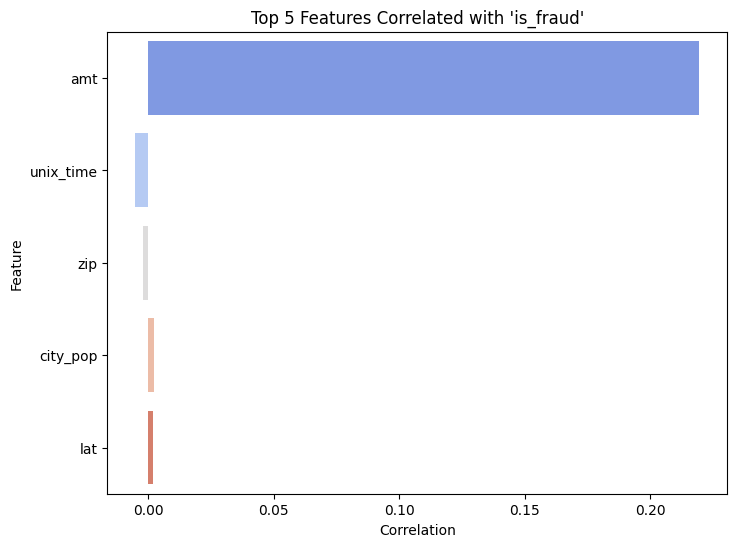

In [ ]:
def num_corr(df, target="is_fraud", n=5):
    # Select numerical columns
    num_cols = df.select_dtypes(include=['int32', 'int64', 'float64'])

    # Pearson correlation matrix
    corr_num = num_cols.corr()

    # If target not in numerical columns
    if target not in corr_num.columns:
        raise ValueError(f"Target '{target}' not found among numerical columns.")

    # Extract correlations with target
    corr_target = corr_num[target].drop(target)  # drop self-correlation

    # Get top n absolute correlations
    top_features = corr_target.abs().sort_values(ascending=False).head(n)
    top_features_signed = corr_target.loc[top_features.index]  # keep sign for bar chart

    # --- Plot heatmap of all correlations ---
    mask = np.triu(np.ones_like(corr_num, dtype=bool))
    plt.figure(figsize=(10,8))
    sns.heatmap(corr_num, mask=mask, cmap="coolwarm", annot=True, fmt=".2f", cbar=True)
    plt.title("Numerical Features Correlation (Pearson)")
    plt.show()

    # --- Plot bar chart of top n correlations ---
    plt.figure(figsize=(8,6))
    sns.barplot(x=top_features_signed.values, y=top_features_signed.index, palette="coolwarm")
    plt.title(f"Top {n} Features Correlated with '{target}'")
    plt.xlabel("Correlation")
    plt.ylabel("Feature")
    plt.show()

num_corr(df_viz)

#### Categorical correlation

In [ ]:
df_viz_samp = df_viz.drop(["trans_date_trans_time", "dob", "trans_num"], axis=1)

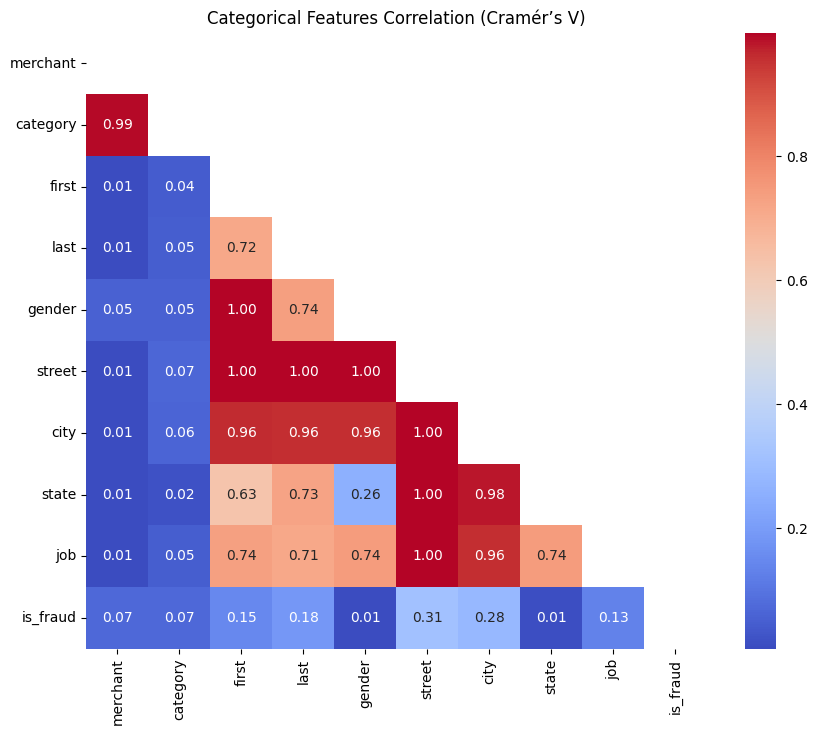

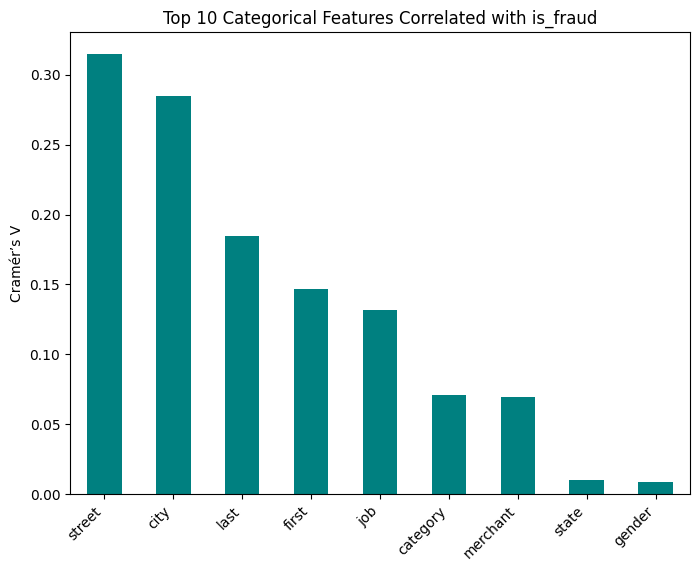

In [ ]:
def cat_corr(df, n=10):
    def cramers_v(x, y):
        confusion_matrix = pd.crosstab(x, y)
        chi2 = chi2_contingency(confusion_matrix)[0]
        n_obs = confusion_matrix.sum().sum()
        phi2 = chi2 / n_obs
        r, k = confusion_matrix.shape
        phi2corr = max(0, phi2 - ((k-1)*(r-1)) / (n_obs-1))
        rcorr = r - ((r-1)**2) / (n_obs-1)
        kcorr = k - ((k-1)**2) / (n_obs-1)
        return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

    # Sample to reduce computation cost
    df_viz_samp = df.sample(frac=0.1, random_state=42)
    df_viz_samp["is_fraud"] = df_viz_samp["is_fraud"].astype("category")
    cat_cols = df_viz_samp.select_dtypes(include=["object", "category"]).astype("category")

    # Compute Cramér’s V with is_fraud
    corr_with_target = {}
    for c in cat_cols.columns:
        if c != "is_fraud":
            corr_with_target[c] = cramers_v(cat_cols[c], df_viz_samp["is_fraud"])

    # Sort by strength
    sorted_corr = pd.Series(corr_with_target).sort_values(ascending=False)

    # --- Heatmap (all categorical pairs) ---
    corr_cat = pd.DataFrame(np.zeros((len(cat_cols.columns), len(cat_cols.columns))),
                            index=cat_cols.columns, columns=cat_cols.columns)
    for c1 in cat_cols.columns:
        for c2 in cat_cols.columns:
            corr_cat.loc[c1, c2] = cramers_v(cat_cols[c1], cat_cols[c2])

    mask = np.triu(np.ones_like(corr_cat, dtype=bool))
    plt.figure(figsize=(10,8))
    sns.heatmap(corr_cat, mask=mask, cmap="coolwarm", annot=True, fmt=".2f", cbar=True)
    plt.title("Categorical Features Correlation (Cramér’s V)")
    plt.show()

    # --- Bar chart (top-N with is_fraud) ---
    plt.figure(figsize=(8,6))
    sorted_corr.head(n).plot(kind="bar", color="teal")
    plt.title(f"Top {n} Categorical Features Correlated with is_fraud")
    plt.ylabel("Cramér’s V")
    plt.xticks(rotation=45, ha="right")
    plt.show()

cat_corr(df_viz_samp)


In [ ]:
df_viz = df_viz.copy()

### Date and Time Heatmap


#### Transaction

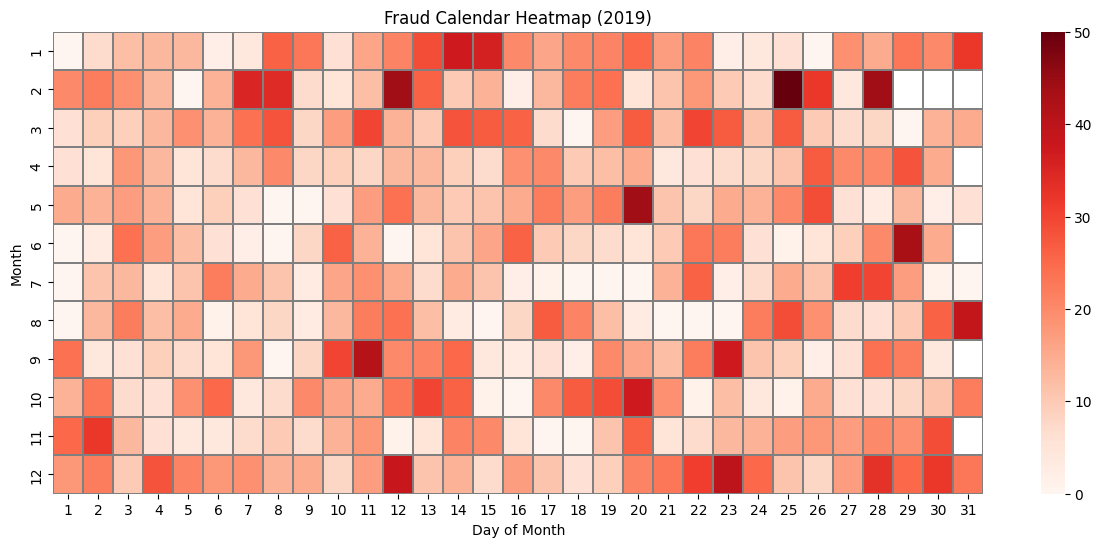

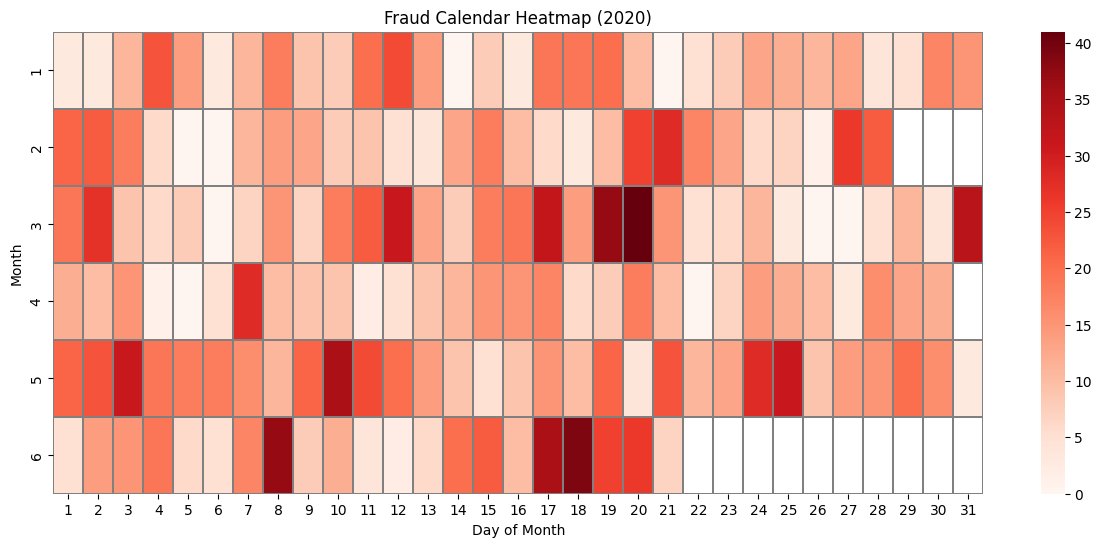

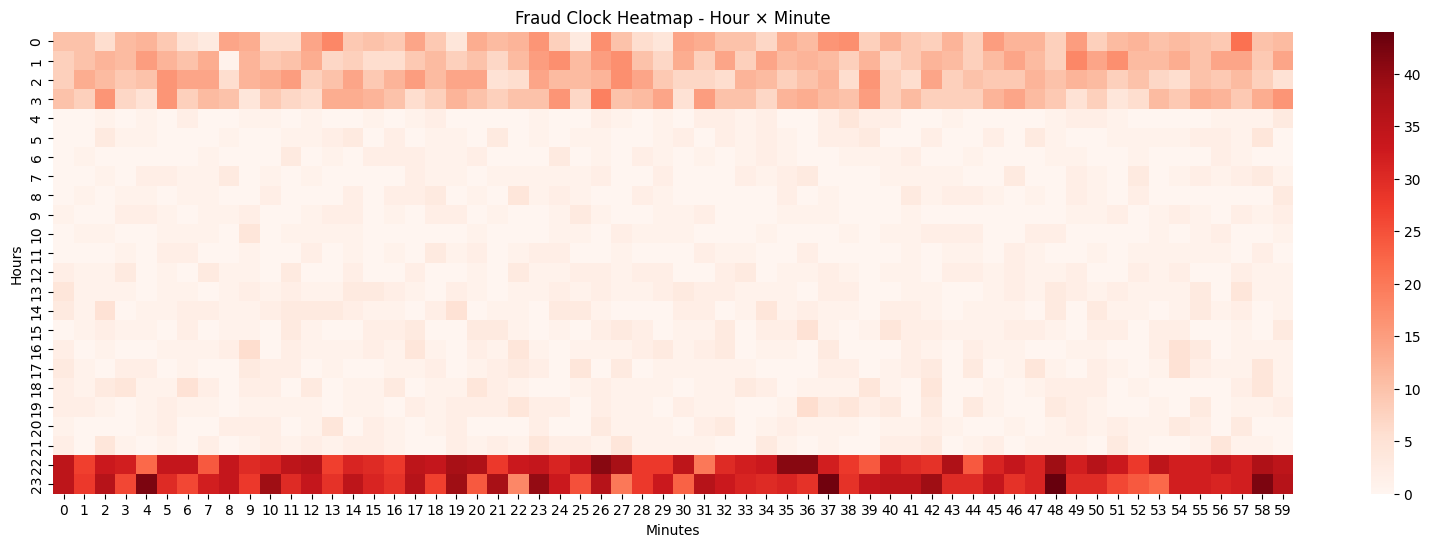

In [ ]:
df_viz["trans_date_trans_time"] = pd.to_datetime(df_viz["trans_date_trans_time"])
df_viz["year"] = df_viz["trans_date_trans_time"].dt.year
df_viz["month"] = df_viz["trans_date_trans_time"].dt.month
df_viz["day"] = df_viz["trans_date_trans_time"].dt.day
df_viz["hour"] = df_viz["trans_date_trans_time"].dt.hour
df_viz["minute"] = df_viz["trans_date_trans_time"].dt.minute
df_viz["second"] = df_viz["trans_date_trans_time"].dt.second

# =====================================================
# 1) CALENDAR HEATMAP (Year × Month × Day)
# =====================================================
fraud_calendar = df_viz.groupby(["year","month","day"])["is_fraud"].sum().reset_index()

for yr in sorted(fraud_calendar["year"].unique()):
    pivoted = fraud_calendar[fraud_calendar["year"]==yr].pivot(
        index="month", columns="day", values="is_fraud"
    )

    plt.figure(figsize=(15,6))
    sns.heatmap(pivoted, cmap="Reds", cbar=True, linewidths=0.1, linecolor="grey")
    plt.title(f"Fraud Calendar Heatmap ({yr})")
    plt.xlabel("Day of Month")
    plt.ylabel("Month")
    plt.show()

# =====================================================
# 2) CLOCK HEATMAP (Hour × Minute)
# =====================================================

fraud_clock_min = df_viz.groupby(["hour","minute"])["is_fraud"].sum().reset_index()

pivoted_clock_min = fraud_clock_min.pivot_table(
    index="hour", columns="minute", values="is_fraud", fill_value=0
)

plt.figure(figsize=(20,6))
sns.heatmap(pivoted_clock_min, cmap="Reds", cbar=True)
plt.title("Fraud Clock Heatmap - Hour × Minute")
plt.xlabel("Minutes")
plt.ylabel("Hours")
plt.show()

#### DoB

In [ ]:
df_viz["dob"] = pd.to_datetime(df_viz["dob"])
df_viz["dob_year"] = df_viz["dob"].dt.year
df_viz["dob_month"] = df_viz["dob"].dt.month
df_viz["dob_day"] = df_viz["dob"].dt.day

In [ ]:
def feature_to_target(df, column):
    partition = df.groupby(column)["is_fraud"].sum().reset_index()

    # reshape into 1-row dataframe
    heatmap_data = partition.set_index(column).T

    plt.figure(figsize=(20, 2))
    sns.heatmap(
        heatmap_data,
        cmap="Reds",
        annot=False,  # disable is_fraud count labels
        cbar=True
    )
    plt.title(f"Fraud Count Heatmap by {column}")
    plt.yticks(rotation=0)
    plt.show()

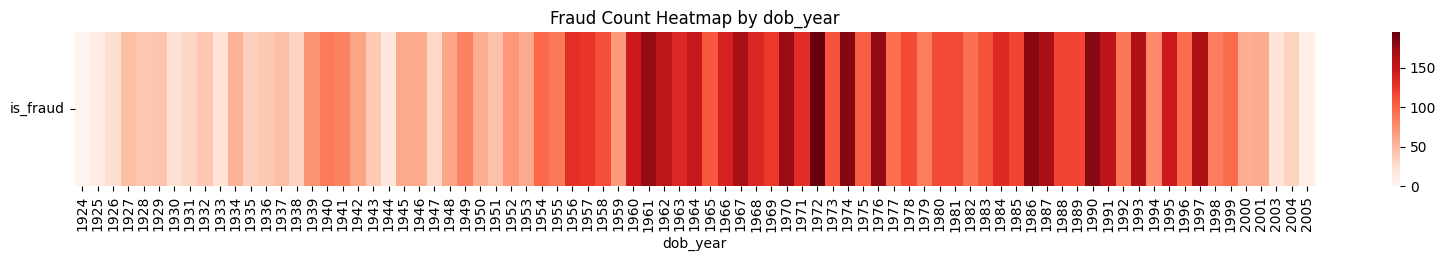

In [ ]:
feature_to_target(df_viz, "dob_year")

### Concatenate customer_name

In [ ]:
df_viz["customer_name"] = df_viz["first"].str.cat(df_viz["last"], sep=' ')

In [ ]:
df_viz["customer_name"].nunique()

973

In [ ]:
df_viz = df_viz.drop(["first", "last"], axis=1)

### Split merchant prefix

In [ ]:
df_viz["merchant"].str.startswith("fraud_").sum()

np.int64(1296675)

### Split street components

In [ ]:
splits = df_viz["street"].str.split(" ", expand=True)

# Assign to new columns sequentially
df_viz["str_number"]    = splits[0]
df_viz["str_name"]      = splits[1]
df_viz["str_type"]      = splits[2]
df_viz["building_type"] = splits[3]
df_viz["room_number"]   = splits[4]

df_viz = df_viz.drop('street', axis=1)

In [ ]:
df_viz.nunique()

,0
trans_date_trans_time,1274791
cc_num,983
merchant,693
category,14
amt,52928
gender,2
city,894
state,51
zip,970
lat,968


### Split zip prefix

In [ ]:
df_viz["zip"] = df_viz["zip"].astype(str).str.zfill(5)

# Extract first 3 digits (ZIP prefix / metro area)
df_viz["zip_prefix"] = df_viz["zip"].str[:3]

In [ ]:
df_viz["zip_prefix"].nunique()

526

In [ ]:
df_viz["zip_prefix"].astype(int)
df_viz = df_viz.drop("zip", axis=1)

### Calculate distance (km) between merchants and customers

In [ ]:
def haversine_vectorized(lat1, lon1, lat2, lon2):
    # Convert to radians
    lat1 = np.radians(lat1)
    lon1 = np.radians(lon1)
    lat2 = np.radians(lat2)
    lon2 = np.radians(lon2)

    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    r = 6371  # Earth radius in kilometers
    return r * c

# Example usage with your DataFrame df
df_viz['distance_km'] = haversine_vectorized(
    df_viz['lat'], df_viz['long'], df_viz['merch_lat'], df_viz['merch_long']
)

df_viz = df_viz.drop(["lat", "long", "merch_lat", "merch_long"], axis=1)

### Calculating age

In [ ]:
df_viz["age"] = df_viz["year"] - df_viz["dob_year"]

### Drop datetime columns (trans_date_trans_time, dob), trans_num

In [ ]:
df_viz_samp_2 = df_viz.drop(["trans_date_trans_time", "dob", "trans_num"], axis=1)

### Correlation after transformation

In [ ]:
target_col = "is_fraud"   # replace with your target column name

# Move target column to the end
def reorder(df):
    cols = [c for c in df.columns if c != target_col] + [target_col]
    df = df[cols]
    return df

df_viz_samp_2 = reorder(df_viz_samp_2)

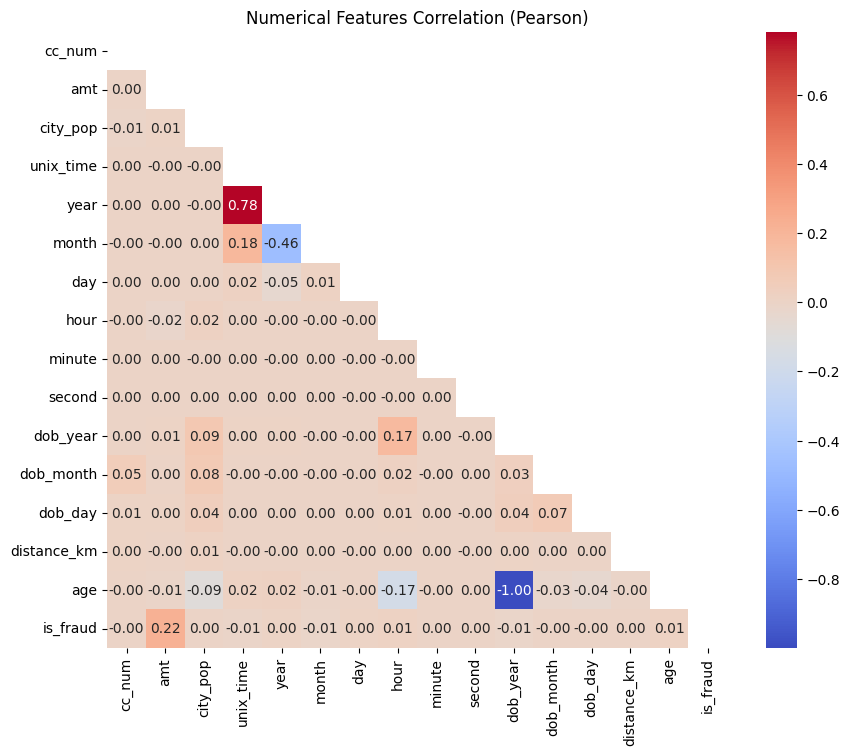

/tmp/ipython-input-170565288.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_features_signed.values, y=top_features_signed.index, palette="coolwarm")


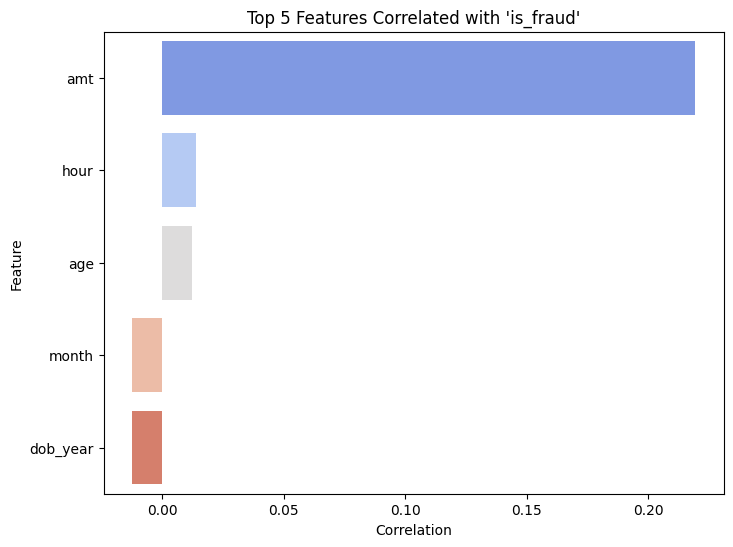

In [ ]:
num_corr(df_viz_samp_2)

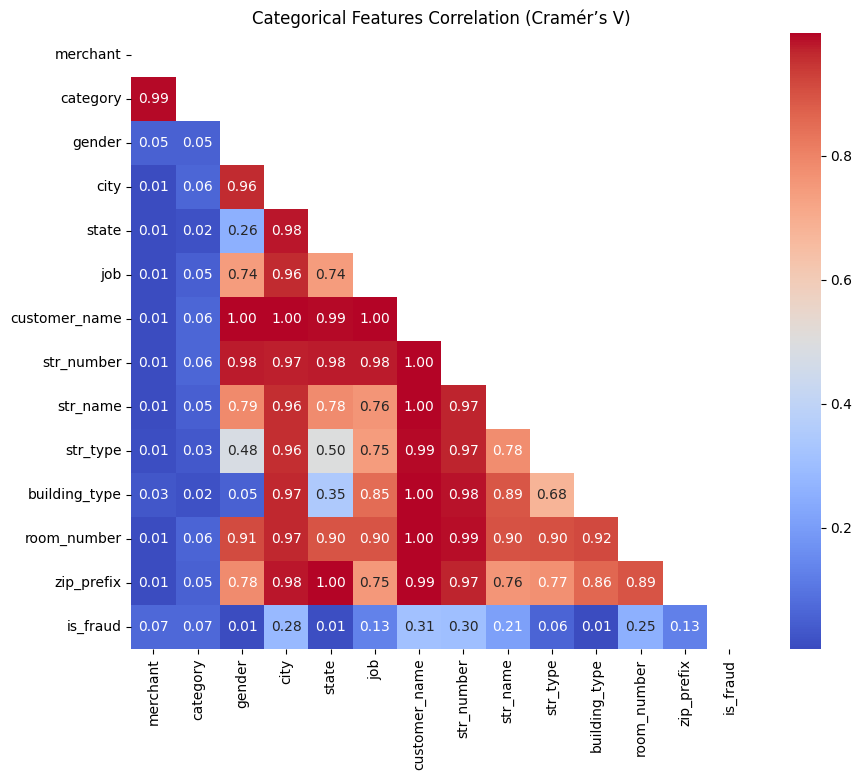

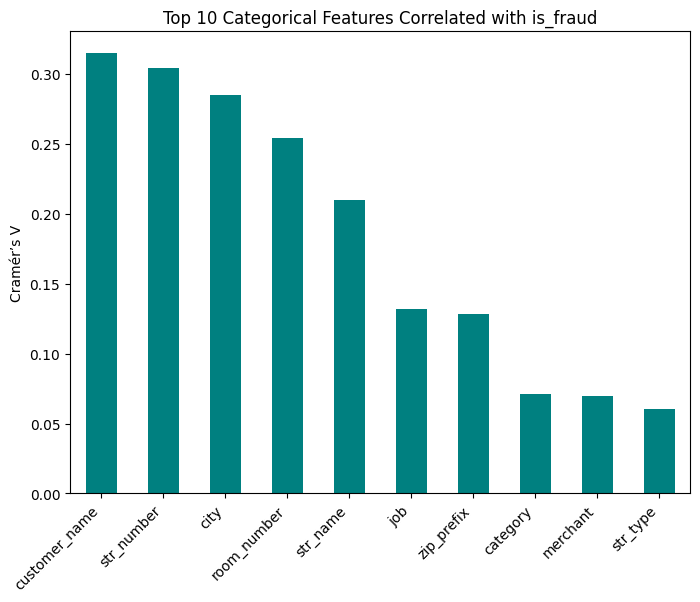

In [ ]:
cat_corr(df_viz_samp_2)

In [ ]:
df_viz.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 32 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   trans_date_trans_time  1296675 non-null  datetime64[ns]
 1   cc_num                 1296675 non-null  int64         
 2   merchant               1296675 non-null  object        
 3   category               1296675 non-null  object        
 4   amt                    1296675 non-null  float64       
 5   gender                 1296675 non-null  object        
 6   city                   1296675 non-null  object        
 7   state                  1296675 non-null  object        
 8   city_pop               1296675 non-null  int64         
 9   job                    1296675 non-null  object        
 10  dob                    1296675 non-null  datetime64[ns]
 11  trans_num              1296675 non-null  object        
 12  unix_time              12966

## Relationship Analysis

### Fraud Rate by Category Spending

/tmp/ipython-input-1570587870.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(fraud_by_cat_amt["category"], rotation=45, ha="right")


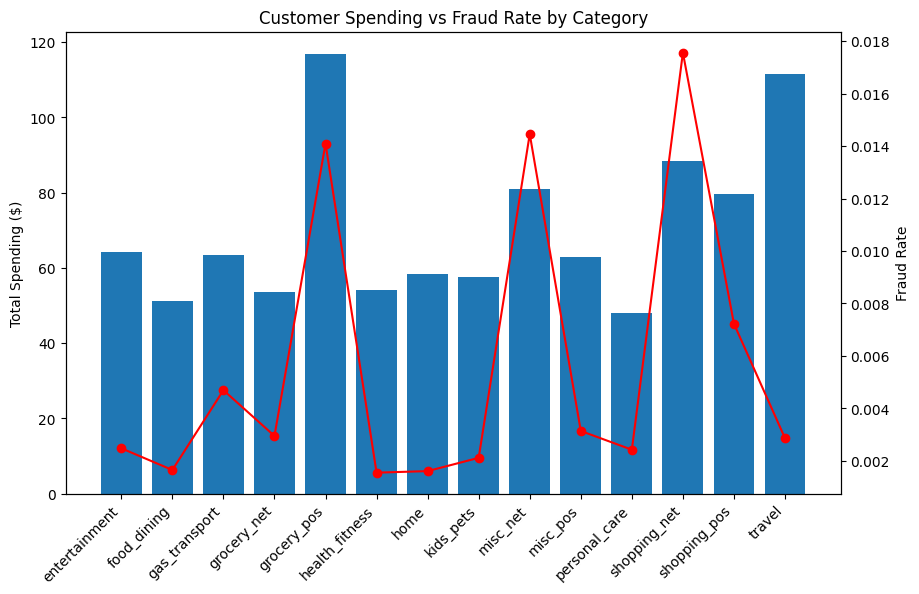

In [ ]:
fraud_by_cat_amt = (
    df_viz.groupby("category")
    .agg(
        total_spent=("amt", "mean"),
        fraud_cases=("is_fraud", "sum"),
        total_transactions=("is_fraud", "count")
    )
    .reset_index()
)

fraud_by_cat_amt["fraud_rate"] = (
    fraud_by_cat_amt["fraud_cases"] / fraud_by_cat_amt["total_transactions"]
)

fig, ax1 = plt.subplots(figsize=(10,6))

# Bar for spending
ax1.bar(fraud_by_cat_amt["category"], fraud_by_cat_amt["total_spent"])
ax1.set_ylabel("Total Spending ($)")
ax1.set_xticklabels(fraud_by_cat_amt["category"], rotation=45, ha="right")

# Second axis for fraud rate
ax2 = ax1.twinx()
ax2.plot(fraud_by_cat_amt["category"], fraud_by_cat_amt["fraud_rate"], color="red", marker="o")
ax2.set_ylabel("Fraud Rate")

plt.title("Customer Spending vs Fraud Rate by Category")
plt.show()

### Fraud Cases by State

In [ ]:
df_state = df_viz.groupby("state")["is_fraud"].sum().reset_index()

fig = px.choropleth(df_state,
                    locations='state',
                    locationmode='USA-states',
                    color='is_fraud',
                    scope="usa",
                    color_continuous_scale="Reds",
                    labels={'is_fraud':'Fraud Rate'}
)
fig.update_layout(title_text="US Fraud Rate by State", geo_scope='usa')
fig.show()

### Total Amount of Transactions by State

In [ ]:
state_amt = df_viz.groupby("state").agg(
    total_amt=("amt", "sum"),
    total_transactions=("amt", "count")
).reset_index()

fig = px.choropleth(state_amt,
                    locations='state',
                    locationmode='USA-states',
                    color='total_amt',
                    scope="usa",
                    color_continuous_scale="Reds",
                    labels={'total_amt':'Total Amount'})

fig.update_layout(title_text="US Total Amount of Transactions by State", geo_scope='usa')
fig.show()

### Fraud Rate by Gender

In [ ]:
fraud_rate_gender = (
    df_viz.groupby("gender")["is_fraud"]
    .agg(["sum", "count"])
    .reset_index()
)

fraud_rate_gender["fraud_rate"] = (
    fraud_rate_gender["sum"] * 100 / fraud_rate_gender["count"]
)

print(fraud_rate_gender)

  gender   sum   count  fraud_rate
0      F  3735  709863    0.526158
1      M  3771  586812    0.642625


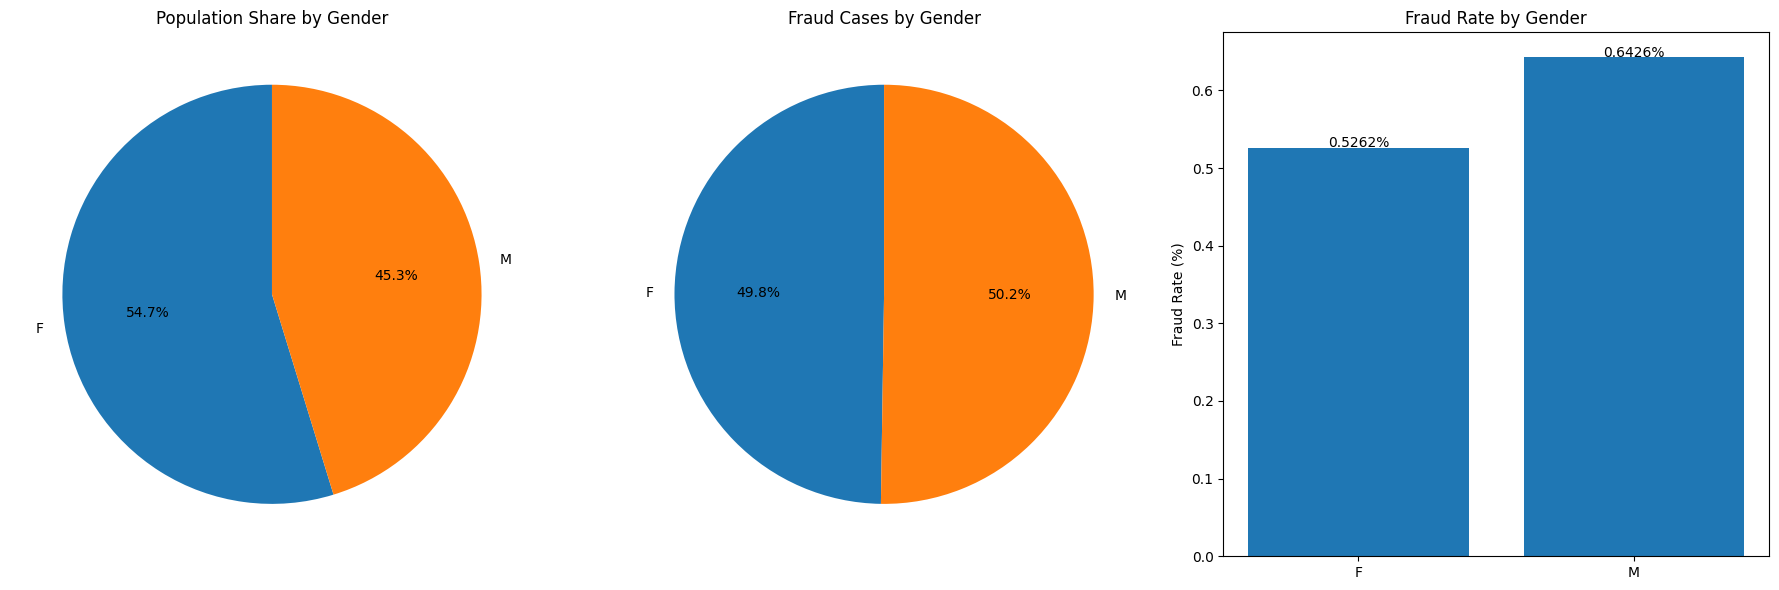

In [ ]:
# --- Data prep ---
# Population distribution
pop_share = fraud_rate_gender.set_index("gender")["count"]

# Fraud case distribution
fraud_cases = fraud_rate_gender.set_index("gender")["sum"]

# Fraud rate (% of each gender)
fraud_rate = fraud_rate_gender.set_index("gender")["fraud_rate"]

# --- Plot ---
fig, axes = plt.subplots(1, 3, figsize=(18,6))

# 1. Population share
axes[0].pie(pop_share, labels=pop_share.index, autopct="%.1f%%", startangle=90)
axes[0].set_title("Population Share by Gender")

# 2. Fraud case share
axes[1].pie(fraud_cases, labels=fraud_cases.index, autopct="%.1f%%", startangle=90)
axes[1].set_title("Fraud Cases by Gender")

# 3. Fraud rate (better as bar than pie because values are very small)
axes[2].bar(fraud_rate.index, fraud_rate.values)
axes[2].set_title("Fraud Rate by Gender")
axes[2].set_ylabel("Fraud Rate (%)")
for i, v in enumerate(fraud_rate.values):
    axes[2].text(i, v + 0.001, f"{v:.4f}%", ha="center")  # show 4 decimals since ~0.05%

plt.tight_layout()
plt.show()

### Amount vs fraud

In [ ]:
df.groupby("is_fraud")["amt"].describe()

,count,mean,std,min,25%,50%,75%,max
is_fraud,,,,,,,,
0,1289169.0,67.667110,154.007971,1.00,9.6100,47.280,82.540,28948.90
1,7506.0,531.320092,390.560070,1.06,245.6625,396.505,900.875,1376.04


In [ ]:
# --- Compute median amount ---
median_amt = df_viz["amt"].median()

# --- Count high-amount frauds per customer (without modifying df) ---
high_amt_fraud_counts = df_viz.loc[(df_viz["amt"] > median_amt) & (df_viz["is_fraud"] == 1)]
customer_counts = high_amt_fraud_counts.groupby("customer_name").size().reset_index(name="num_high_amt_fraud")

# Average number of high-amount frauds per customer
avg_high_amt_fraud_per_customer = customer_counts["num_high_amt_fraud"].mean()

# Total number of high-amount transactions
total_high_amt = df_viz["amt"].loc[df_viz["amt"] > median_amt].mean()

# Compute ratio
ratio = avg_high_amt_fraud_per_customer*100 / total_high_amt

print(f"Probability that a transaction with higher than median amount is fradulent: {ratio:.2f}%")

Probability that a transaction with higher than median amount is fradulent: 6.37%


In [ ]:
from scipy.stats import pointbiserialr
corr, pval = pointbiserialr(df["amt"], df["is_fraud"])
print(corr, pval)

0.2194038889588689 0.0


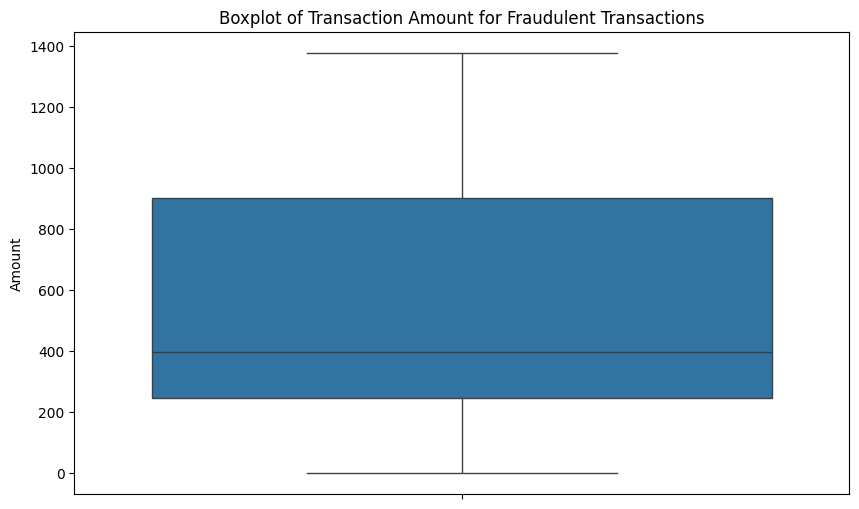

In [ ]:
# Filter the DataFrame to include only fraudulent transactions
fraud_df = df_viz[df_viz['is_fraud'] == 1]

plt.figure(figsize=(10, 6))
sns.boxplot(y=fraud_df['amt'])
plt.title('Boxplot of Transaction Amount for Fraudulent Transactions')
plt.ylabel('Amount')
plt.show()

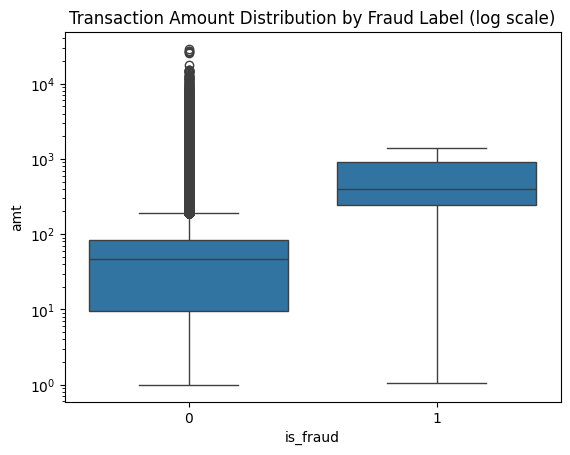

/tmp/ipython-input-1754773778.py:8: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



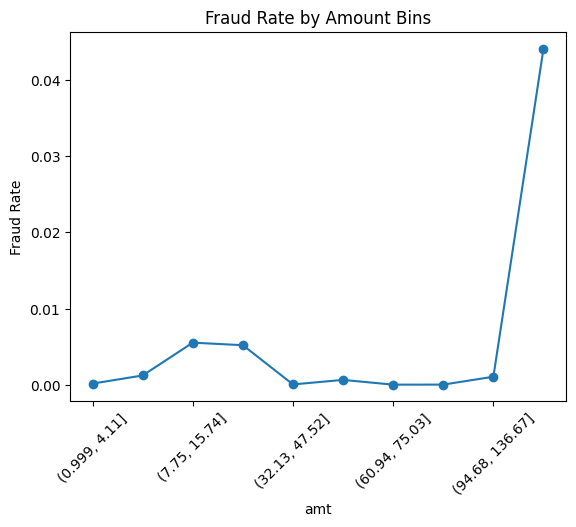

Correlation: 0.2194038889588689 p-value: 0.0


In [ ]:
sns.boxplot(x="is_fraud", y="amt", data=df_viz)
plt.yscale("log")
plt.title("Transaction Amount Distribution by Fraud Label (log scale)")
plt.show()

# --- Fraud rate by amount bins (quantiles) ---
amount_bins = pd.qcut(df_viz["amt"], q=10)  # 10 quantile bins
fraud_rate = df_viz.groupby(amount_bins)["is_fraud"].mean()

fraud_rate.plot(kind="line", marker="o", title="Fraud Rate by Amount Bins")
plt.ylabel("Fraud Rate")
plt.xticks(rotation=45)
plt.show()

# --- Point-biserial correlation ---
corr, pval = pointbiserialr(df_viz["amt"], df_viz["is_fraud"])
print("Correlation:", corr, "p-value:", pval)

### Analyze fraud rate by time difference


In [ ]:
df_viz_date = df_viz.sort_values(by=["cc_num", "trans_date_trans_time"])
df_viz_date["time_delta"] = df_viz_date.groupby("cc_num")["trans_date_trans_time"].diff().dt.total_seconds() / 3600

/tmp/ipython-input-3246032655.py:5: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



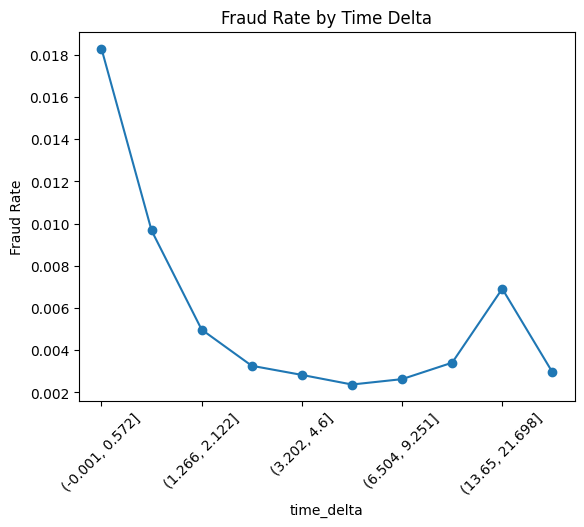

In [ ]:
# Create quantile bins on the fly
time_bins = pd.qcut(df_viz_date["time_delta"].dropna(), q=10)

# Group by bins and compute fraud rate
fraud_rate_by_bin = df_viz_date.groupby(time_bins)["is_fraud"].mean()

# Plot
fraud_rate_by_bin.plot(kind="line", marker="o", title="Fraud Rate by Time Delta")
plt.ylabel("Fraud Rate")
plt.xticks(rotation=45)
plt.show()

### Fraud by Generations


In [ ]:
def categorize_generation(year):
    if 1924 <= year <= 1945:
        return "The Silent: 1924-1945"
    elif 1946 <= year <= 1964:
        return "Baby Boomer: 1946-1964"
    elif 1965 <= year <= 1979:
        return "Gen X: 1965-1979"
    elif 1980 <= year <= 1994:
        return "Millennials: 1980-1994"
    else:
        return "Gen Z: 1995+"

df_viz['generations'] = df_viz['dob_year'].apply(categorize_generation)

In [ ]:
fraud_customers = (
    df_viz[df_viz["is_fraud"] == 1]
    .groupby("generations")["customer_name"]
    .nunique()
    .reset_index(name="n_customers_with_fraud")
)

total_customers = (
    df_viz.groupby("generations")["customer_name"]
    .nunique()
    .reset_index(name="n_customers")
)

fraud_by_generation = fraud_customers.merge(total_customers, on="generations")

count_fraud_generation = fraud_by_generation.copy()

fraud_by_generation["fraud_ratio"] = (
    fraud_by_generation["n_customers_with_fraud"]
    / fraud_by_generation["n_customers"]
)

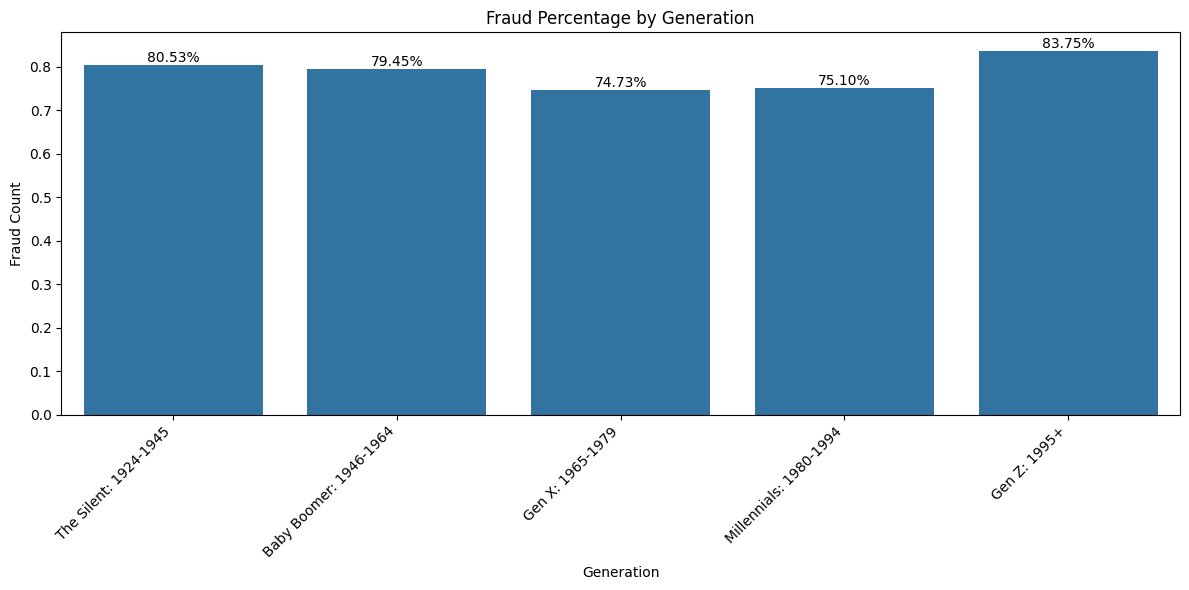

In [ ]:
# Define the desired order of generations
generation_order = [
    "The Silent: 1924-1945",
    "Baby Boomer: 1946-1964",
    "Gen X: 1965-1979",
    "Millennials: 1980-1994",
    "Gen Z: 1995+"
]

# # Convert 'generation' to a categorical type with the specified order
fraud_by_generation['generations'] = pd.Categorical(
    fraud_by_generation['generations'], categories=generation_order, ordered=True
)

# Sort by the categorical 'generation' column
fraud_by_generation = fraud_by_generation.sort_values('generations')

plt.figure(figsize=(12, 6))
ax = sns.barplot(
    data=fraud_by_generation,
    x='generations',
    y='fraud_ratio',
     )

# Add ratio labels on top of bars (as %)
for p in ax.patches:
    ax.annotate(
        f"{p.get_height():.2%}",  # format as percentage
        (p.get_x() + p.get_width() / 2, p.get_height()),
        ha="center", va="bottom",
        fontsize=10, color="black"
    )

plt.title("Fraud Percentage by Generation")
plt.xlabel("Generation")
plt.ylabel("Fraud Count")
plt.xticks(rotation=45, ha='right') # Rotate labels for better readability
plt.tight_layout()
plt.show()

# Step 3: Preprocessing

## 3.1. Train set preprocessing

## Time

In [ ]:
df["trans_date_trans_time"] = pd.to_datetime(df["trans_date_trans_time"])
df["year"] = df["trans_date_trans_time"].dt.year
df["month"] = df["trans_date_trans_time"].dt.month
df["day"] = df["trans_date_trans_time"].dt.day
df["hour"] = df["trans_date_trans_time"].dt.hour
df["minute"] = df["trans_date_trans_time"].dt.minute
df["second"] = df["trans_date_trans_time"].dt.second

### Day vs Night


In [ ]:
df['time_of_day'] = df['hour'].apply(categorize_time_of_day)

### Time Delta

In [ ]:
df = df.sort_values(by=["cc_num", "trans_date_trans_time"])

# Calculate time difference between 2 transactions of the same cc_num
df["prev_txn_date"] = df.groupby("cc_num")["trans_date_trans_time"].shift(1)
df["time_delta"] = (df["trans_date_trans_time"] - df["prev_txn_date"]).dt.total_seconds() / 3600  # by hours

### Split DoB

In [ ]:
df["dob"] = pd.to_datetime(df["dob"])
df["dob_year"] = df["dob"].dt.year
df["dob_month"] = df["dob"].dt.month
df["dob_day"] = df["dob"].dt.day


### Calculating age

In [ ]:
df["age"] = df["year"] - df["dob_year"]

### Rewrite unix_time

In [ ]:
# As the original unix_time is not appropriate, decoding unix_time gives another date different from the trans_date, I will drop it
df = df.drop("unix_time", axis=1)

In [ ]:
df["trans_date_trans_time"] = pd.to_datetime(df["trans_date_trans_time"])

# Create a new column with unix_time (seconds since epoch)
df["unix_time"] = df["trans_date_trans_time"].astype(int) // 10**9

## Split street components

In [ ]:
splits = df["street"].str.split(" ", expand=True)

# Assign to new columns sequentially
df["str_number"]    = splits[0]
df["str_name"]      = splits[1]
df["str_type"]      = splits[2]
df["building_type"] = splits[3]
df["room_number"]   = splits[4]

df = df.drop('street', axis=1)

## Split zip prefix

In [ ]:
df["zip"] = df["zip"].astype(str).str.zfill(5)

# Extract first 3 digits (ZIP prefix / metro area)
df["zip_prefix"] = df["zip"].str[:3]

In [ ]:
df["zip_prefix"].astype(int)
df = df.drop("zip", axis=1)

## Calculate distance (km) between merchants and customers

In [ ]:
df['distance_km'] = haversine_vectorized(
    df['lat'], df['long'], df['merch_lat'], df['merch_long']
)

df = df.drop(["lat", "long", "merch_lat", "merch_long"], axis=1)

## Overwrite job

In [ ]:
# Overwrite 'job' with only the first element before the comma
df["job"] = df["job"].str.split(",").str[0].str.strip()

## Generations

In [ ]:
df['generations'] = df['dob_year'].apply(categorize_generation)

## Prepare train set

In [ ]:
df_train = df.drop(columns=["first", "last","str_number","room_number","cc_num","trans_date_trans_time", "prev_txn_date","unix_time", "dob","trans_num","city","building_type"],axis=1)

In [ ]:
df_train.select_dtypes(include=['object', 'category']).nunique()

,0
merchant,693
category,14
gender,2
state,51
job,415
str_name,552
str_type,193
building_type,3
zip_prefix,526
time_of_day,2


In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1296675 entries, 1017 to 1296427
Data columns (total 25 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   merchant     1296675 non-null  object 
 1   category     1296675 non-null  object 
 2   amt          1296675 non-null  float64
 3   gender       1296675 non-null  object 
 4   state        1296675 non-null  object 
 5   city_pop     1296675 non-null  int64  
 6   job          1296675 non-null  object 
 7   is_fraud     1296675 non-null  int64  
 8   year         1296675 non-null  int32  
 9   month        1296675 non-null  int32  
 10  day          1296675 non-null  int32  
 11  hour         1296675 non-null  int32  
 12  minute       1296675 non-null  int32  
 13  second       1296675 non-null  int32  
 14  time_of_day  1296675 non-null  object 
 15  time_delta   1295692 non-null  float64
 16  dob_year     1296675 non-null  int32  
 17  dob_month    1296675 non-null  int32  
 18  dob_

In [ ]:
df_train=df_train.dropna()

## Encode train

In [ ]:
!pip install category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 4.5 MB/s eta 0:00:00


In [ ]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from category_encoders import TargetEncoder

train_encoded = df_train.copy()

# --------------------------
# 1. Frequency Encoding
# --------------------------
freq_cols = ["merchant", "state", "str_name", "str_type","job","zip_prefix"]
for col in freq_cols:
    freq_map = train_encoded[col].value_counts(normalize=True)  # tỷ lệ xuất hiện
    train_encoded[col + "_freq"] = train_encoded[col].map(freq_map)

# --------------------------
# 2. One-Hot Encoding
# --------------------------
onehot_cols = ["category", "gender", "time_of_day"]
train_encoded = pd.get_dummies(train_encoded, columns=onehot_cols, drop_first=True)

# --------------------------
# 3. Label Encoding
# --------------------------
label_col = "generations"
le = LabelEncoder()
train_encoded[label_col] = le.fit_transform(train_encoded[label_col])

# --------------------------
# Done
# --------------------------
train_encoded = train_encoded.drop(columns=freq_cols  + [label_col])
df_train_encoded = train_encoded.copy()


In [ ]:
df_train_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1295692 entries, 2724 to 1296427
Data columns (total 36 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   amt                      1295692 non-null  float64
 1   city_pop                 1295692 non-null  int64  
 2   is_fraud                 1295692 non-null  int64  
 3   year                     1295692 non-null  int32  
 4   month                    1295692 non-null  int32  
 5   day                      1295692 non-null  int32  
 6   hour                     1295692 non-null  int32  
 7   minute                   1295692 non-null  int32  
 8   second                   1295692 non-null  int32  
 9   time_delta               1295692 non-null  float64
 10  dob_year                 1295692 non-null  int32  
 11  dob_month                1295692 non-null  int32  
 12  dob_day                  1295692 non-null  int32  
 13  age                      1295692 non-null  i

In [ ]:
target_col = "is_fraud"

#Move target column to the end
cols = [c for c in df_train_encoded if c != target_col] + [target_col]
df_train_encoded = df_train_encoded[cols]

## 3.2. Test set processing
### Follow the same process as train

In [ ]:
# Set pandas option to display all columns
pd.set_option('display.max_columns', None)

# Optional: Set the width to avoid line breaks
pd.set_option('display.width', None)

df_test = pd.read_csv('fraudTest.csv', on_bad_lines='warn')  # or 'skip' or 'error'
df_test

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2020-06-21 12:14:25,2291163933867244,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,351 Darlene Green,Columbia,SC,29209,33.9659,-80.9355,333497,Mechanical engineer,1968-03-19,2da90c7d74bd46a0caf3777415b3ebd3,1371816865,33.986391,-81.200714,0
1,1,2020-06-21 12:14:33,3573030041201292,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,F,3638 Marsh Union,Altonah,UT,84002,40.3207,-110.4360,302,"Sales professional, IT",1990-01-17,324cc204407e99f51b0d6ca0055005e7,1371816873,39.450498,-109.960431,0
2,2,2020-06-21 12:14:53,3598215285024754,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,Ashley,Lopez,F,9333 Valentine Point,Bellmore,NY,11710,40.6729,-73.5365,34496,"Librarian, public",1970-10-21,c81755dbbbea9d5c77f094348a7579be,1371816893,40.495810,-74.196111,0
3,3,2020-06-21 12:15:15,3591919803438423,fraud_Haley Group,misc_pos,60.05,Brian,Williams,M,32941 Krystal Mill Apt. 552,Titusville,FL,32780,28.5697,-80.8191,54767,Set designer,1987-07-25,2159175b9efe66dc301f149d3d5abf8c,1371816915,28.812398,-80.883061,0
4,4,2020-06-21 12:15:17,3526826139003047,fraud_Johnston-Casper,travel,3.19,Nathan,Massey,M,5783 Evan Roads Apt. 465,Falmouth,MI,49632,44.2529,-85.0170,1126,Furniture designer,1955-07-06,57ff021bd3f328f8738bb535c302a31b,1371816917,44.959148,-85.884734,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
555714,555714,2020-12-31 23:59:07,30560609640617,fraud_Reilly and Sons,health_fitness,43.77,Michael,Olson,M,558 Michael Estates,Luray,MO,63453,40.4931,-91.8912,519,Town planner,1966-02-13,9b1f753c79894c9f4b71f04581835ada,1388534347,39.946837,-91.333331,0
555715,555715,2020-12-31 23:59:09,3556613125071656,fraud_Hoppe-Parisian,kids_pets,111.84,Jose,Vasquez,M,572 Davis Mountains,Lake Jackson,TX,77566,29.0393,-95.4401,28739,Futures trader,1999-12-27,2090647dac2c89a1d86c514c427f5b91,1388534349,29.661049,-96.186633,0
555716,555716,2020-12-31 23:59:15,6011724471098086,fraud_Rau-Robel,kids_pets,86.88,Ann,Lawson,F,144 Evans Islands Apt. 683,Burbank,WA,99323,46.1966,-118.9017,3684,Musician,1981-11-29,6c5b7c8add471975aa0fec023b2e8408,1388534355,46.658340,-119.715054,0
555717,555717,2020-12-31 23:59:24,4079773899158,fraud_Breitenberg LLC,travel,7.99,Eric,Preston,M,7020 Doyle Stream Apt. 951,Mesa,ID,83643,44.6255,-116.4493,129,Cartographer,1965-12-15,14392d723bb7737606b2700ac791b7aa,1388534364,44.470525,-117.080888,0


In [ ]:
df_test = df_test.drop('Unnamed: 0', axis=1)

In [ ]:
#split datetime
df_test["trans_date_trans_time"] = pd.to_datetime(df_test["trans_date_trans_time"])
df_test["year"] = df_test["trans_date_trans_time"].dt.year
df_test["month"] = df_test["trans_date_trans_time"].dt.month
df_test["day"] = df_test["trans_date_trans_time"].dt.day
df_test["hour"] = df_test["trans_date_trans_time"].dt.hour
df_test["minute"] = df_test["trans_date_trans_time"].dt.minute
df_test["second"] = df_test["trans_date_trans_time"].dt.second

In [ ]:
#split DOB
df_test["dob"] = pd.to_datetime(df_test["dob"])
df_test["dob_year"] = df_test["dob"].dt.year
df_test["dob_month"] = df_test["dob"].dt.month
df_test["dob_day"] = df_test["dob"].dt.day

In [ ]:
#Age
df_test["age"] = df_test["year"] - df_test["dob_year"]

In [ ]:
df_test["zip"] = df_test["zip"].astype(str).str.zfill(5)

# Extract first 3 digits (ZIP prefix / metro area)
df_test["zip_prefix"] = df_test["zip"].str[:3]
df_test = df_test.drop("zip", axis=1)

In [ ]:
#calculate distance
df_test['distance_km'] = haversine_vectorized(
    df_test['lat'], df_test['long'], df_test['merch_lat'], df_test['merch_long']
)

df_test = df_test.drop(["lat", "long", "merch_lat", "merch_long"], axis=1)

In [ ]:
df_test["job"] = df_test["job"].str.split(",").str[0].str.strip()

In [ ]:
splits_test = df_test["street"].str.split(" ", expand=True)

# Assign to new columns sequentially
df_test["str_number"]    = splits[0]
df_test["str_name"]      = splits[1]
df_test["str_type"]      = splits[2]
df_test["building_type"] = splits[3]
df_test["room_number"]   = splits[4]

df_test = df_test.drop('street', axis=1)

In [ ]:
df_test['time_of_day'] = df_test['hour'].apply(categorize_time_of_day)

In [ ]:
#time delta
df_test = df_test.sort_values(by=["cc_num", "trans_date_trans_time"])

df_test["prev_txn_date"] = df_test.groupby("cc_num")["trans_date_trans_time"].shift(1)
df_test["time_delta"] = (df_test["trans_date_trans_time"] - df_test["prev_txn_date"]).dt.total_seconds() / 3600  # tính theo giờ

In [ ]:
#generation
df_test['generations'] = df_test['dob_year'].apply(categorize_generation)

In [ ]:
df_test = df_test.drop(columns=["first","last","trans_num","str_number","room_number","city","cc_num","trans_date_trans_time", "prev_txn_date","unix_time", "dob","building_type"],axis=1)

In [ ]:
df_test = df_test.dropna()

In [ ]:
df_test

,merchant,category,amt,gender,state,city_pop,job,is_fraud,year,month,day,hour,minute,second,dob_year,dob_month,dob_day,age,zip_prefix,distance_km,str_name,str_type,time_of_day,time_delta,generations
741,fraud_Halvorson Group,misc_pos,78.52,F,WY,1645,Information systems manager,0,2020,6,21,16,25,36,1986,2,17,34,825,91.942935,Green,Forks,Day,3.331667,Millennials: 1980-1994
3047,fraud_Conroy-Cruickshank,gas_transport,65.25,F,WY,1645,Information systems manager,0,2020,6,22,7,58,33,1986,2,17,34,825,121.857420,Peterson,Land,Day,15.549167,Millennials: 1980-1994
4351,fraud_Larkin Ltd,kids_pets,87.74,F,WY,1645,Information systems manager,0,2020,6,22,15,32,31,1986,2,17,34,825,65.414164,Yu,Locks,Day,7.566111,Millennials: 1980-1994
7695,fraud_Leffler-Goldner,personal_care,148.02,F,WY,1645,Information systems manager,0,2020,6,23,12,28,54,1986,2,17,34,825,38.311273,William,Dale,Day,20.939722,Millennials: 1980-1994
8059,"fraud_Kihn, Abernathy and Douglas",shopping_net,2.83,F,WY,1645,Information systems manager,0,2020,6,23,14,24,48,1986,2,17,34,825,61.986305,Mckenzie,Stream,Day,1.931667,Millennials: 1980-1994
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
552584,fraud_Parisian and Sons,gas_transport,66.11,M,IL,532,Audiological scientist,0,2020,12,31,2,10,10,1956,1,9,64,613,44.885043,Chad,Lake,Night,2.243611,Baby Boomer: 1946-1964
552892,fraud_Bogisich-Homenick,misc_net,4.58,M,IL,532,Audiological scientist,0,2020,12,31,5,13,35,1956,1,9,64,613,81.485915,Luna,Brook,Night,3.056944,Baby Boomer: 1946-1964
553559,fraud_Erdman-Kertzmann,gas_transport,95.96,M,IL,532,Audiological scientist,0,2020,12,31,11,15,44,1956,1,9,64,613,36.046110,David,Locks,Day,6.035833,Baby Boomer: 1946-1964
553560,fraud_Stracke-Lemke,grocery_pos,149.48,M,IL,532,Audiological scientist,0,2020,12,31,11,17,25,1956,1,9,64,613,81.769332,Morgan,River,Day,0.028056,Baby Boomer: 1946-1964


In [ ]:
df_test.info()
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 554795 entries, 741 to 553883
Data columns (total 25 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   merchant     554795 non-null  object 
 1   category     554795 non-null  object 
 2   amt          554795 non-null  float64
 3   gender       554795 non-null  object 
 4   state        554795 non-null  object 
 5   city_pop     554795 non-null  int64  
 6   job          554795 non-null  object 
 7   is_fraud     554795 non-null  int64  
 8   year         554795 non-null  int32  
 9   month        554795 non-null  int32  
 10  day          554795 non-null  int32  
 11  hour         554795 non-null  int32  
 12  minute       554795 non-null  int32  
 13  second       554795 non-null  int32  
 14  dob_year     554795 non-null  int32  
 15  dob_month    554795 non-null  int32  
 16  dob_day      554795 non-null  int32  
 17  age          554795 non-null  int32  
 18  zip_prefix   554795 non-nul

In [ ]:
# match train columns
df_test = df_test[df_train.columns]

In [ ]:
test_encoded = df_test.copy()

# --------------------------
# 1. Frequency Encoding
# --------------------------
for col in freq_cols:
    freq_map = df_train[col].value_counts(normalize=True)  # lấy map từ train
    test_encoded[col + "_freq"] = test_encoded[col].map(freq_map).fillna(0)

# --------------------------
# 2. One-Hot Encoding
# --------------------------
test_encoded = pd.get_dummies(test_encoded, columns=onehot_cols, drop_first=True)

# Add new columns to align with train
missing_cols = set(train_encoded.columns) - set(test_encoded.columns)
for col in missing_cols:
    test_encoded[col] = 0

# --------------------------
# 3. Label Encoding
# --------------------------
test_encoded[label_col] = test_encoded[label_col].map(
    lambda x: le.transform([x])[0] if x in le.classes_ else -1
)

# --------------------------
# 4. Drop original categorical
# --------------------------
test_encoded = test_encoded.drop(columns=freq_cols + [label_col])

# --------------------------
# 5. Reorder columns
# --------------------------
test_encoded = test_encoded[df_train_encoded.columns]

df_test_encoded = test_encoded.copy()

print("Test set encoded shape:", df_test_encoded.shape)
display(df_test_encoded.head())

Test set encoded shape: (554795, 36)


,amt,city_pop,year,month,day,hour,minute,second,time_delta,dob_year,dob_month,dob_day,age,distance_km,merchant_freq,state_freq,str_name_freq,str_type_freq,job_freq,zip_prefix_freq,category_food_dining,category_gas_transport,category_grocery_net,category_grocery_pos,category_health_fitness,category_home,category_kids_pets,category_misc_net,category_misc_pos,category_personal_care,category_shopping_net,category_shopping_pos,category_travel,gender_M,time_of_day_Night,is_fraud
741,78.52,1645,2020,6,21,16,25,36,3.331667,1986,2,17,34,91.942935,0.001231,0.014903,0.002357,0.004743,0.001558,0.004265,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,0
3047,65.25,1645,2020,6,22,7,58,33,15.549167,1986,2,17,34,121.857420,0.002007,0.014903,0.000813,0.007465,0.001558,0.004265,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,0
4351,87.74,1645,2020,6,22,15,32,31,7.566111,1986,2,17,34,65.414164,0.001732,0.014903,0.001544,0.006711,0.001558,0.004265,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,0
7695,148.02,1645,2020,6,23,12,28,54,20.939722,1986,2,17,34,38.311273,0.001429,0.014903,0.003584,0.009102,0.001558,0.004265,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,0
8059,2.83,1645,2020,6,23,14,24,48,1.931667,1986,2,17,34,61.986305,0.001456,0.014903,0.003485,0.010306,0.001558,0.004265,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,0


In [ ]:
df_test_encoded.info()
df_train_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 554795 entries, 741 to 553883
Data columns (total 36 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   amt                      554795 non-null  float64
 1   city_pop                 554795 non-null  int64  
 2   year                     554795 non-null  int32  
 3   month                    554795 non-null  int32  
 4   day                      554795 non-null  int32  
 5   hour                     554795 non-null  int32  
 6   minute                   554795 non-null  int32  
 7   second                   554795 non-null  int32  
 8   time_delta               554795 non-null  float64
 9   dob_year                 554795 non-null  int32  
 10  dob_month                554795 non-null  int32  
 11  dob_day                  554795 non-null  int32  
 12  age                      554795 non-null  int32  
 13  distance_km              554795 non-null  float64
 14  merchan

In [ ]:
# --- 1. Split features & target ---
X_train = df_train_encoded.drop("is_fraud", axis=1)
y_train = df_train_encoded["is_fraud"]

X_test = df_test_encoded.drop("is_fraud", axis=1)
y_test = df_test_encoded["is_fraud"]

# --- 2. Scale features (LR cần chuẩn hoá) ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Feature Importance


## Random Forest Feature Importance

Top 15 Features quan trọng nhất theo Random Forest:
                 feature  importance
0                    amt    0.399787
5                   hour    0.084738
14         merchant_freq    0.052317
13            time_delta    0.047109
16         str_name_freq    0.046174
12                   age    0.036455
8               dob_year    0.035178
21  category_grocery_pos    0.029277
11           distance_km    0.024268
1               city_pop    0.023828
17         str_type_freq    0.019729
6                 minute    0.019094
7                 second    0.019004
4                    day    0.018379
15            state_freq    0.015554


<Figure size 1200x800 with 0 Axes>

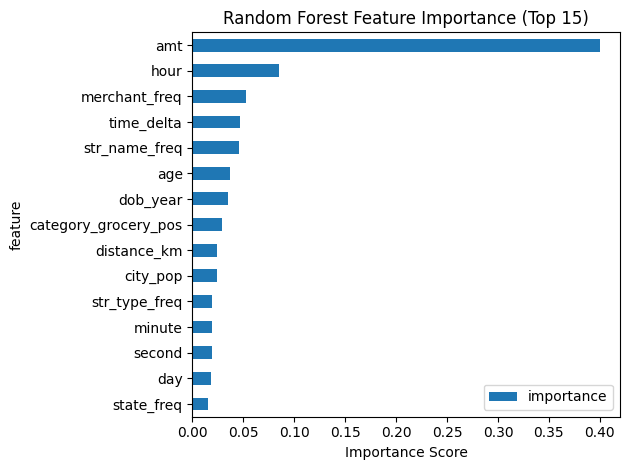


Random Forest Accuracy: 0.9985


In [ ]:
# Random Forest Feature Importance
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train_scaled, y_train)

# Lấy feature importance
rf_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_classifier.feature_importances_
}).sort_values('importance', ascending=False)

print("Top 15 Features quan trọng nhất theo Random Forest:")
print(rf_importance.head(15))

# Vẽ biểu đồ
plt.figure(figsize=(12, 8))
rf_importance.head(15).plot(x='feature', y='importance', kind='barh')
plt.title('Random Forest Feature Importance (Top 15)')
plt.xlabel('Importance Score')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Accuracy với Random Forest
rf_pred = rf_classifier.predict(X_test_scaled)
rf_accuracy = accuracy_score(y_test, rf_pred)
print(f"\nRandom Forest Accuracy: {rf_accuracy:.4f}")

## Logistic Regression Weights (Feature Coefficients)

Top 15 Features quan trọng nhất theo Logistic Regression (theo giá trị tuyệt đối):
                    feature  coefficient  abs_coefficient
32        time_of_day_Night     1.189702         1.189702
30          category_travel    -1.059409         1.059409
21     category_grocery_pos     0.919261         0.919261
5                      hour     0.819985         0.819985
19   category_gas_transport     0.679107         0.679107
25        category_misc_net     0.540773         0.540773
28    category_shopping_net     0.450841         0.450841
0                       amt     0.421409         0.421409
20     category_grocery_net     0.402622         0.402622
13               time_delta    -0.349969         0.349969
23            category_home    -0.242773         0.242773
3                     month    -0.219062         0.219062
29    category_shopping_pos     0.212413         0.212413
16            str_name_freq    -0.207474         0.207474
22  category_health_fitness    -0.198623       

<Figure size 1200x800 with 0 Axes>

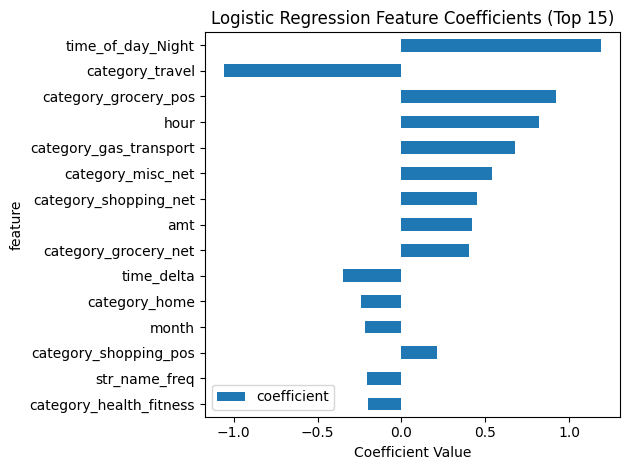


Logistic Regression Accuracy: 0.9959


In [ ]:
# Logistic Regression Feature Importance (weights/coefficients)
lr_classifier = LogisticRegression(random_state=42, max_iter=1000)
lr_classifier.fit(X_train_scaled, y_train)

# Lấy coefficients (weights)
lr_importance = pd.DataFrame({
    'feature': X_train.columns,
    'coefficient': lr_classifier.coef_[0],
    'abs_coefficient': np.abs(lr_classifier.coef_[0])
}).sort_values('abs_coefficient', ascending=False)

print("Top 15 Features quan trọng nhất theo Logistic Regression (theo giá trị tuyệt đối):")
print(lr_importance.head(15))

# Vẽ biểu đồ coefficients
plt.figure(figsize=(12, 8))
lr_importance.head(15).plot(x='feature', y='coefficient', kind='barh')
plt.title('Logistic Regression Feature Coefficients (Top 15)')
plt.xlabel('Coefficient Value')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Accuracy với Logistic Regression
lr_pred = lr_classifier.predict(X_test_scaled)
lr_accuracy = accuracy_score(y_test, lr_pred)
print(f"\nLogistic Regression Accuracy: {lr_accuracy:.4f}")

# Step 4: Train model

## 4.1. Base model

In [ ]:
#Train Logistic Regression ---
lr = LogisticRegression(
    class_weight="balanced",
    solver="lbfgs",
    max_iter=1000,
    random_state=42
)
lr.fit(X_train_scaled, y_train)

# --- 4. Evaluate ---
y_pred = lr.predict(X_test_scaled)
y_prob = lr.predict_proba(X_test_scaled)[:, 1]

print("Classification report:")
print(classification_report(y_test, y_pred, digits=4))

print("ROC-AUC:", roc_auc_score(y_test, y_prob))
print("PR-AUC:", average_precision_score(y_test, y_prob))

Classification report:
              precision    recall  f1-score   support

           0     0.9989    0.9168    0.9561    269997
           1     0.0332    0.7423    0.0636      1040

    accuracy                         0.9162    271037
   macro avg     0.5161    0.8296    0.5099    271037
weighted avg     0.9952    0.9162    0.9527    271037

ROC-AUC: 0.9377158108024564
PR-AUC: 0.14902037410216804


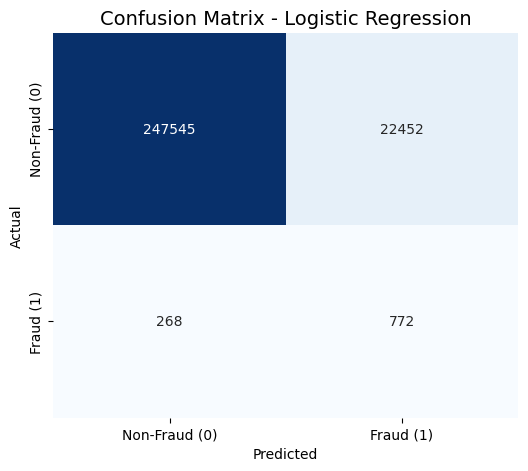

In [ ]:
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    average_precision_score,
    confusion_matrix
)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Non-Fraud (0)", "Fraud (1)"],
            yticklabels=["Non-Fraud (0)", "Fraud (1)"])
plt.title("Confusion Matrix - Logistic Regression", fontsize=14)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [ ]:
# Train RandomForest model
rf = RandomForestClassifier(class_weight="balanced", random_state=42)
rf.fit(X_train_scaled, y_train)

# Evaluate RandomForest model
y_pred_rf = rf.predict(X_test_scaled)
y_prob_rf = rf.predict_proba(X_test_scaled)[:, 1]

print("RandomForest Classification Report:")
print(classification_report(y_test, y_pred_rf, digits=4))
print("RandomForest ROC-AUC:", roc_auc_score(y_test, y_prob_rf))
print("RandomForest PR-AUC:", average_precision_score(y_test, y_prob_rf))

RandomForest Classification Report:
              precision    recall  f1-score   support

           0     0.9987    1.0000    0.9993    269997
           1     0.9818    0.6740    0.7993      1040

    accuracy                         0.9987    271037
   macro avg     0.9903    0.8370    0.8993    271037
weighted avg     0.9987    0.9987    0.9986    271037

RandomForest ROC-AUC: 0.9802243814105057
RandomForest PR-AUC: 0.8744083369676964


In [ ]:
!pip install xgboost

In [ ]:
# Calculate scale_pos_weight
# Assuming y_train is your training target variable before resampling
neg_count = y_train.value_counts()[0]
pos_count = y_train.value_counts()[1]
scale_pos_weight_value = neg_count / pos_count

# Train XGBoost model
xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss', scale_pos_weight=scale_pos_weight_value) # Added use_label_encoder and eval_metric and scale_pos_weight
xgb.fit(X_train_scaled, y_train)

# Evaluate XGBoost model
y_pred_xgb = xgb.predict(X_test_scaled)
y_prob_xgb = xgb.predict_proba(X_test_scaled)[:, 1]

print("XGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb, digits=4))
print("XGBoost ROC-AUC:", roc_auc_score(y_test, y_prob_xgb))
print("XGBoost PR-AUC:", average_precision_score(y_test, y_prob_xgb))

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning:

[16:01:25] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.




XGBoost Classification Report:
              precision    recall  f1-score   support

           0     0.9997    0.9967    0.9982    269997
           1     0.5162    0.9202    0.6614      1040

    accuracy                         0.9964    271037
   macro avg     0.7579    0.9584    0.8298    271037
weighted avg     0.9978    0.9964    0.9969    271037

XGBoost ROC-AUC: 0.9980990850040784
XGBoost PR-AUC: 0.9078737658885507


## 4.2 Resampling data

In [ ]:
!pip install imbalanced-learn

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

# Define the undersampling strategy
# We want to reduce the majority class size to about half of its original size.
# The original majority class size is approximately 1,288,261.
# Half of that is around 644,130. Let's use a value around 600,000 for demonstration.
rus = RandomUnderSampler(sampling_strategy={0: 600000, 1: len(y_train[y_train == 1])}, random_state=42)

# Apply undersampling to the training data
X_train_undersampled, y_train_undersampled = rus.fit_resample(X_train_scaled, y_train)

print("Shape of X_train_scaled after undersampling:", X_train_undersampled.shape)
print("Shape of y_train_scaled after undersampling:", y_train_undersampled.shape)
print("Distribution of the target variable after undersampling:")
print(pd.Series(y_train_undersampled).value_counts())

Shape of X_train_scaled after undersampling: (607431, 35)
Shape of y_train_scaled after undersampling: (607431,)
Distribution of the target variable after undersampling:
is_fraud
0    600000
1      7431
Name: count, dtype: int64


In [ ]:
from imblearn.over_sampling import SMOTE

# Define the SMOTE strategy
# We want to oversample the minority class (fraud) to have the same number of samples
# as the majority class after undersampling.
smote = SMOTE(sampling_strategy='minority', random_state=42)

# Apply SMOTE to the undersampled training data
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_undersampled, y_train_undersampled)

print("Shape of X_train_scaled after SMOTE:", X_train_resampled.shape)
print("Shape of y_train_scaled after SMOTE:", y_train_resampled.shape)
print("Distribution of the target variable after SMOTE:")
print(pd.Series(y_train_resampled).value_counts())

Shape of X_train_scaled after SMOTE: (1200000, 35)
Shape of y_train_scaled after SMOTE: (1200000,)
Distribution of the target variable after SMOTE:
is_fraud
0    600000
1    600000
Name: count, dtype: int64


## 4.3. Train and Evaluate Models on Resampled Data

### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score

# Train Logistic Regression model on resampled data
lr_resampled = LogisticRegression(
    class_weight="balanced", # Use balanced class weight as a starting point, though SMOTE might make it less necessary
    solver="lbfgs",
    max_iter=1000,
    random_state=42
)
lr_resampled.fit(X_train_resampled, y_train_resampled)

# Evaluate Logistic Regression on the original test data
y_pred_lr_resampled = lr_resampled.predict(X_test_scaled)
y_prob_lr_resampled = lr_resampled.predict_proba(X_test_scaled)[:, 1]

print("Logistic Regression Classification Report (Resampled Data):")
print(classification_report(y_test, y_pred_lr_resampled, digits=4))
print("Logistic Regression ROC-AUC (Resampled Data):", roc_auc_score(y_test, y_prob_lr_resampled))
print("Logistic Regression PR-AUC (Resampled Data):", average_precision_score(y_test, y_prob_lr_resampled))

Logistic Regression Classification Report (Resampled Data):
              precision    recall  f1-score   support

           0     0.9989    0.9268    0.9615    269997
           1     0.0370    0.7308    0.0705      1040

    accuracy                         0.9261    271037
   macro avg     0.5180    0.8288    0.5160    271037
weighted avg     0.9952    0.9261    0.9581    271037

Logistic Regression ROC-AUC (Resampled Data): 0.9363533099085716
Logistic Regression PR-AUC (Resampled Data): 0.14958764567391683


### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score

# Train RandomForest model on resampled data
rf_resampled = RandomForestClassifier(max_depth=25, random_state=42)
rf_resampled.fit(X_train_resampled, y_train_resampled)

# Evaluate RandomForest model on the original test data
y_pred_rf_resampled = rf_resampled.predict(X_test_scaled)
y_prob_rf_resampled = rf_resampled.predict_proba(X_test_scaled)[:, 1]

print("RandomForest Classification Report (Resampled Data):")
print(classification_report(y_test, y_pred_rf_resampled, digits=4))
print("RandomForest ROC-AUC (Resampled Data):", roc_auc_score(y_test, y_prob_rf_resampled))
print("RandomForest PR-AUC (Resampled Data):", average_precision_score(y_test, y_prob_rf_resampled))

RandomForest Classification Report (Resampled Data):
              precision    recall  f1-score   support

           0     0.9994    0.9987    0.9991    269997
           1     0.7177    0.8433    0.7754      1040

    accuracy                         0.9981    271037
   macro avg     0.8585    0.9210    0.8872    271037
weighted avg     0.9983    0.9981    0.9982    271037

RandomForest ROC-AUC (Resampled Data): 0.9928529992925846
RandomForest PR-AUC (Resampled Data): 0.8612582810299857


Top 20 most important features:
                   feature  importance
0                      amt    0.454660
5                     hour    0.154008
32       time_of_day_Night    0.113390
14           merchant_freq    0.037255
13              time_delta    0.026850
28   category_shopping_net    0.016854
21    category_grocery_pos    0.016828
19  category_gas_transport    0.016296
31                gender_M    0.013622
3                    month    0.011951
16           str_name_freq    0.011472
8                 dob_year    0.010973
12                     age    0.010636
9                dob_month    0.007829
1                 city_pop    0.007700
17           str_type_freq    0.006792
23           category_home    0.006757
25       category_misc_net    0.006241
4                      day    0.006201
15              state_freq    0.006132


/tmp/ipython-input-1800840648.py:13: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




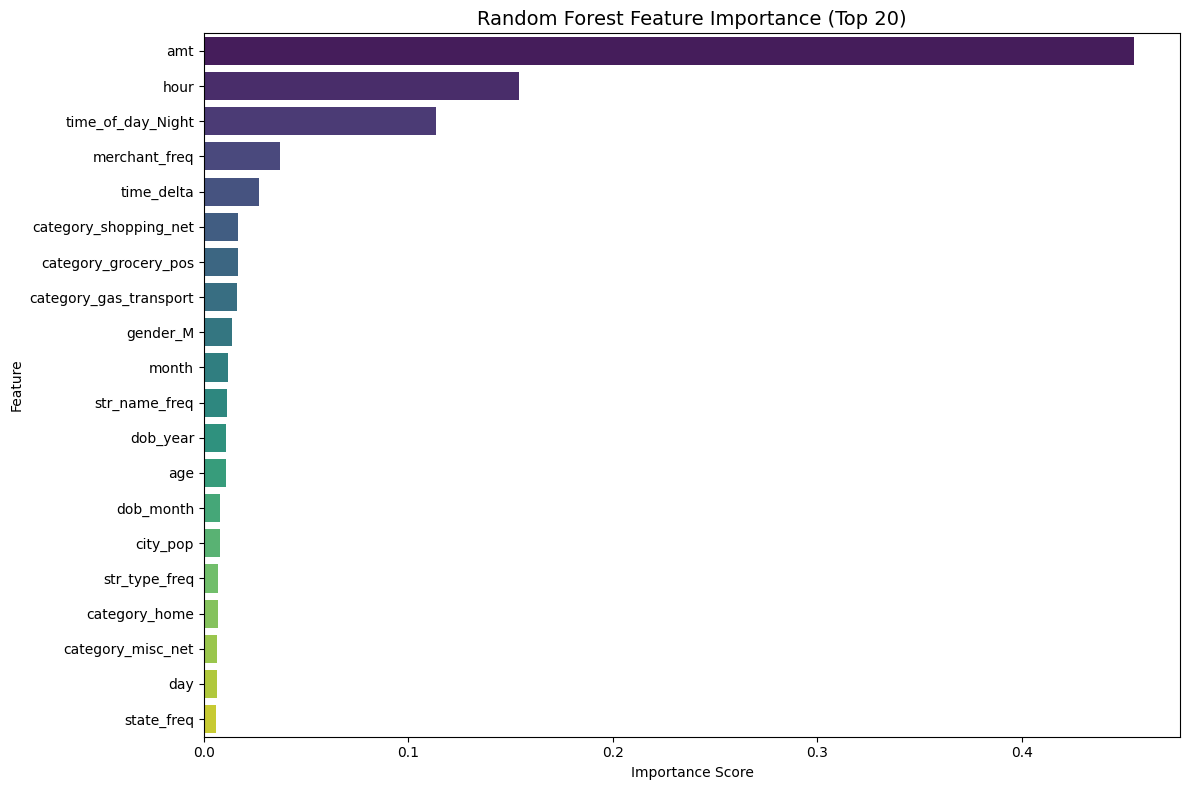

In [ ]:
# Get feature importances
rf_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_resampled.feature_importances_
}).sort_values('importance', ascending=False)

# Show top 20
print("Top 20 most important features:")
print(rf_importance.head(20))

# Plot
plt.figure(figsize=(12, 8))
sns.barplot(
    data=rf_importance.head(20),
    x='importance',
    y='feature',
    palette='viridis'
)
plt.title('Random Forest Feature Importance (Top 20)', fontsize=14)
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

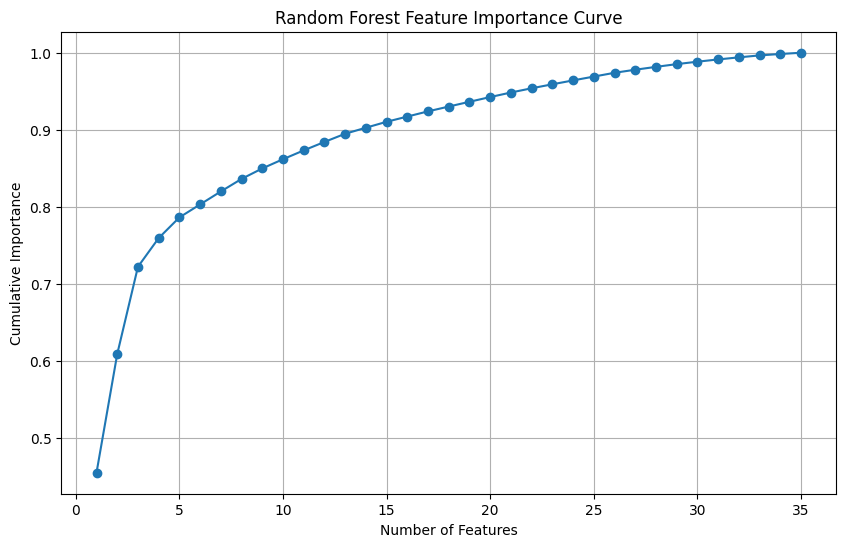

90% of importance is explained by top 14 features
95% of importance is explained by top 22 features
99% of importance is explained by top 31 features


In [ ]:
# Sort features by importance
rf_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_resampled.feature_importances_
}).sort_values('importance', ascending=False)

# Compute cumulative importance
rf_importance['cumulative_importance'] = np.cumsum(rf_importance['importance'])

# Plot feature importance curve
plt.figure(figsize=(10,6))
plt.plot(range(1, len(rf_importance)+1), rf_importance['cumulative_importance'], marker='o')
plt.xlabel("Number of Features")
plt.ylabel("Cumulative Importance")
plt.title("Random Forest Feature Importance Curve")
plt.grid(True)
plt.show()

# Optionally: show number of features explaining 90%, 95%, 99%
for threshold in [0.90, 0.95, 0.99]:
    n_features = np.argmax(rf_importance['cumulative_importance'] >= threshold) + 1
    print(f"{threshold*100:.0f}% of importance is explained by top {n_features} features")

### XGBoost

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score

xgb_resampled = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_resampled.fit(X_train_resampled, y_train_resampled)

# Evaluate XGBoost model on the original test data
y_pred_xgb_resampled = xgb_resampled.predict(X_test_scaled)
y_prob_xgb_resampled = xgb_resampled.predict_proba(X_test_scaled)[:, 1]

print("XGBoost Classification Report (Resampled Data):")
print(classification_report(y_test, y_pred_xgb_resampled, digits=4))
print("XGBoost ROC-AUC (Resampled Data):", roc_auc_score(y_test, y_prob_xgb_resampled))
print("XGBoost PR-AUC (Resampled Data):", average_precision_score(y_test, y_prob_xgb_resampled))

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning:

[16:42:41] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.




XGBoost Classification Report (Resampled Data):
              precision    recall  f1-score   support

           0     0.9994    0.9988    0.9991    269997
           1     0.7338    0.8510    0.7881      1040

    accuracy                         0.9982    271037
   macro avg     0.8666    0.9249    0.8936    271037
weighted avg     0.9984    0.9982    0.9983    271037

XGBoost ROC-AUC (Resampled Data): 0.9968246014699309
XGBoost PR-AUC (Resampled Data): 0.8912745181434827


<Figure size 1200x800 with 0 Axes>

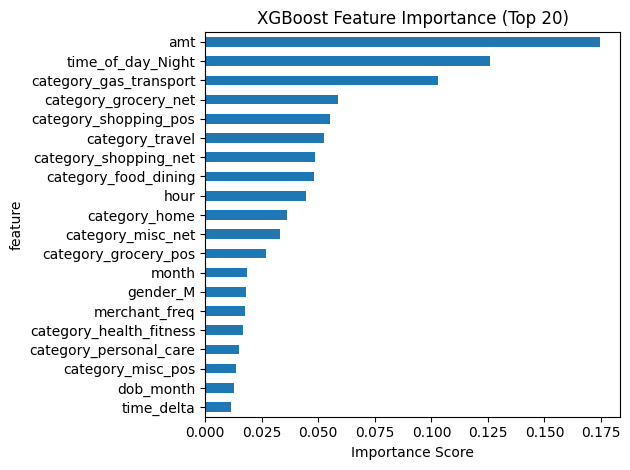

In [ ]:
# Get feature importances from XGBoost
xgb_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': xgb_resampled.feature_importances_
}).sort_values('importance', ascending=False)

# Plot top 15
plt.figure(figsize=(12,8))
xgb_importance.head(20).plot(x='feature', y='importance', kind='barh', legend=False)
plt.title("XGBoost Feature Importance (Top 20)")
plt.xlabel("Importance Score")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

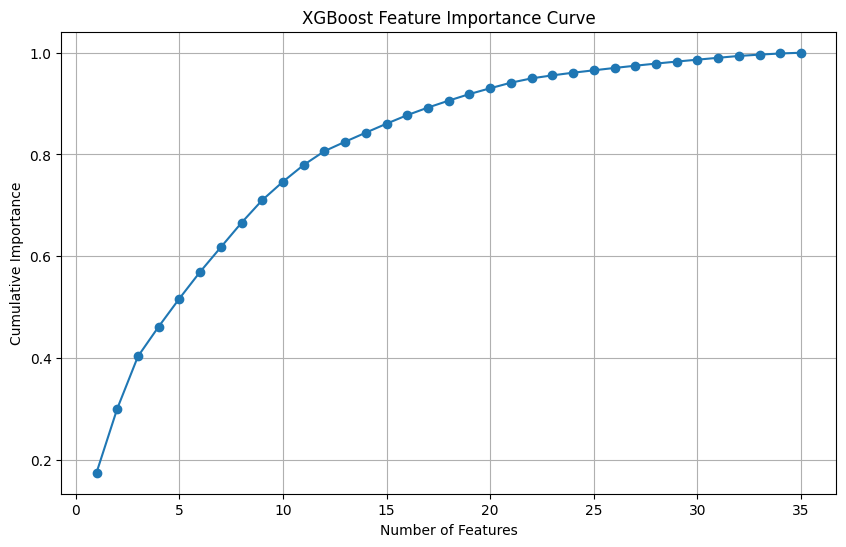

85% of importance is explained by top 15 features
90% of importance is explained by top 18 features
95% of importance is explained by top 23 features
99% of importance is explained by top 31 features


In [ ]:
# Compute cumulative importance
xgb_importance['cumulative_importance'] = np.cumsum(xgb_importance['importance'])

# Plot cumulative curve
plt.figure(figsize=(10,6))
plt.plot(range(1, len(xgb_importance)+1), xgb_importance['cumulative_importance'], marker='o')
plt.xlabel("Number of Features")
plt.ylabel("Cumulative Importance")
plt.title("XGBoost Feature Importance Curve")
plt.grid(True)
plt.show()

# Print how many features explain 90%, 95%, 99%
for threshold in [0.85, 0.90, 0.95, 0.99]:
    n_features = np.argmax(xgb_importance['cumulative_importance'] >= threshold) + 1
    print(f"{threshold*100:.0f}% of importance is explained by top {n_features} features")


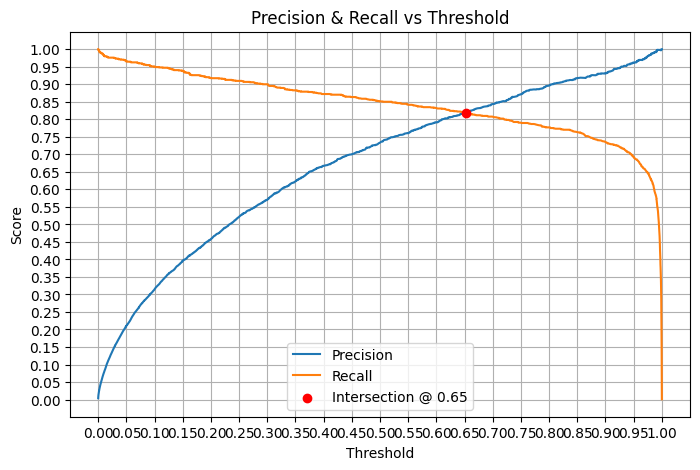

Intersection point threshold: 0.65, Precision=0.82, Recall=0.82


In [ ]:
from sklearn.metrics import precision_recall_curve

# Compute precision, recall, thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_prob_xgb_resampled)

# Find where |precision - recall| is minimal
diff = np.abs(precision[:-1] - recall[:-1])
idx = np.argmin(diff)
best_threshold = thresholds[idx]

# Plot
plt.figure(figsize=(8,5))
plt.plot(thresholds, precision[:-1], label="Precision")
plt.plot(thresholds, recall[:-1], label="Recall")

# Mark intersection point
plt.scatter(
    best_threshold, precision[idx],
    color="red", zorder=5, label=f"Intersection @ {best_threshold:.2f}"
)

plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision & Recall vs Threshold")
plt.legend()
plt.grid()

# 👇 Set y-axis ticks every 0.5
plt.xticks(np.arange(0, 1.05, 0.05))
plt.yticks(np.arange(0, 1.05, 0.05))

plt.show()

print(f"Intersection point threshold: {best_threshold:.2f}, Precision={precision[idx]:.2f}, Recall={recall[idx]:.2f}")

In [ ]:
# Apply custom threshold
threshold = 0.65
y_pred_xgb_resampled = (y_prob_xgb_resampled >= threshold).astype(int)

# Evaluation
print(f"XGBoost Classification Report (Threshold={threshold}):")
print(classification_report(y_test, y_pred_xgb_resampled, digits=4))
print("XGBoost ROC-AUC (Resampled Data):", roc_auc_score(y_test, y_prob_xgb_resampled))
print("XGBoost PR-AUC (Resampled Data):", average_precision_score(y_test, y_prob_xgb_resampled))

XGBoost Classification Report (Threshold=0.65):
              precision    recall  f1-score   support

           0     0.9993    0.9993    0.9993    269997
           1     0.8170    0.8202    0.8186      1040

    accuracy                         0.9986    271037
   macro avg     0.9082    0.9097    0.9090    271037
weighted avg     0.9986    0.9986    0.9986    271037

XGBoost ROC-AUC (Resampled Data): 0.9968246014699309
XGBoost PR-AUC (Resampled Data): 0.8912745181434827
